In [1]:
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset,random_split
from vit_pytorch import ViT
from vit_pytorch.vit import Transformer, Attention
import pandas as pd
import seaborn as sns

/home/exouser/VSCODE_NN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Upload

In [2]:
data_path = "filtered_species"
batch_size = 64

transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),  #Resize to minimum of all sizes - Will update size in cnn architecture
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.RandomRotation(degrees = 30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

data = datasets.ImageFolder(root=data_path, transform=transform)


subset_size = 5000
indices = random.sample(range(len(data)), subset_size)
data_subset = Subset(data, indices)

#change data_subset <-> data for train from whole data
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
training, testing = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(1111))

training_dataset = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
testing_dataset = DataLoader(testing, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
#For testing purposes
#print("Class names:", data.classes)
#len(data.classes)

### Classifier Architecture

In [ ]:
class BirdClassifier(nn.Module):
    def __init__(self,
                 cnn_state=False, # Whether to use CNN before ViT
                 image_size=256,
                 patch_size=16,
                 num_class=10,
                 dim=256,
                 layer_count=1,
                 head_count=1,
                 transformer_ff_neurons=256,
                 transformer_dropout=0.2):
        super().__init__()
        
        self.cnn_state = cnn_state
        self.image_size = image_size if not cnn_state else 64  # Will update if CNN is used

        if cnn_state:
            self.cnn = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # AlexNet
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                
                nn.Conv2d(96, 256, kernel_size=5, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),

                nn.Conv2d(256, 384, kernel_size=3, padding=1),
                nn.ReLU(),

                nn.Conv2d(384, 384, kernel_size=3, padding=1),
                nn.ReLU(),

                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((self.image_size, self.image_size))  # Resize to ViT input
            )

        self.vision_transformer = ViT(
            image_size=self.image_size,
            patch_size=patch_size,
            num_classes=num_class,
            dim=dim,
            depth=layer_count,
            heads=head_count,
            mlp_dim=transformer_ff_neurons,
            dropout=transformer_dropout,
            emb_dropout=transformer_dropout,
            channels=3
        )

    def forward(self, x):
        if self.cnn_state:
            x = self.cnn(x)
        x = self.vision_transformer(x)
        return x





In [3]:
def train_model(model, dataloader, criterion, optimizer_metric, accuracy_metric, device):
    model.train()
    net_loss = 0
    for images, labels in tqdm(dataloader, desc = "TRAINIGN"):
        images, labels = images.to(device), labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat, labels)
        optimizer_metric.zero_grad()
        loss.backward()
        optimizer_metric.step()
        accuracy_metric.update(y_hat, labels)
        net_loss += loss.item()
    
    epoch_accuracy = accuracy_metric.compute().item()
    epoch_loss = net_loss/(len(dataloader))

    return epoch_accuracy, epoch_loss

def test_model(model, dataloader, criterion, accuracy_metric, device):
    model.eval()
    net_loss = 0
    for images, labels in tqdm(dataloader, desc = "TESTING"):
        image, label = images.to(device), labels.to(device)
        y_hat = model(image)
        loss = criterion(y_hat, label)
        accuracy_metric.update(y_hat, label)
        net_loss += loss.item()
    
    epoch_accuracy = accuracy_metric.compute().item()
    epoch_loss = net_loss/(len(dataloader))

    return epoch_accuracy, epoch_loss

### Baseline Model (Control)

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BirdClassifier(cnn_state=False).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train = []
accuracy_scores_train = []
loss_scores_test = []
accuracy_scores_test = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train.append(train_acc)
    loss_scores_train.append(train_loss)

    accuracy_scores_test.append(test_acc)
    loss_scores_test.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    scheduler.step()
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.08it/s]


Train Acc: 0.1999 | Train Loss: 2.1461 | Test Acc: 0.2077 | Test Loss: 2.0597201707411785

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.74it/s]


Train Acc: 0.2239 | Train Loss: 2.0433 | Test Acc: 0.2275 | Test Loss: 2.062566318479525

Epoch 3


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.88it/s]


Train Acc: 0.2399 | Train Loss: 1.9977 | Test Acc: 0.2428 | Test Loss: 2.010009292031632

Epoch 4


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.84it/s]


Train Acc: 0.2521 | Train Loss: 1.9662 | Test Acc: 0.2536 | Test Loss: 2.02152043378272

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.53it/s]


Train Acc: 0.2612 | Train Loss: 1.9441 | Test Acc: 0.2627 | Test Loss: 1.957131569888316

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.34it/s]


Train Acc: 0.2680 | Train Loss: 1.9366 | Test Acc: 0.2695 | Test Loss: 1.8932990735890913

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.72it/s]


Train Acc: 0.2741 | Train Loss: 1.9204 | Test Acc: 0.2749 | Test Loss: 1.9492886788180086

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.59it/s]


Train Acc: 0.2787 | Train Loss: 1.9078 | Test Acc: 0.2795 | Test Loss: 1.9112320019274343

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.89it/s]


Train Acc: 0.2827 | Train Loss: 1.8997 | Test Acc: 0.2836 | Test Loss: 1.9010956441464066

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.01it/s]


Train Acc: 0.2866 | Train Loss: 1.8885 | Test Acc: 0.2873 | Test Loss: 1.93024543840058

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.65it/s]


Train Acc: 0.2903 | Train Loss: 1.8674 | Test Acc: 0.2912 | Test Loss: 1.8576252622669245

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.01it/s]


Train Acc: 0.2938 | Train Loss: 1.8586 | Test Acc: 0.2946 | Test Loss: 1.8584014193541338

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.52it/s]


Train Acc: 0.2969 | Train Loss: 1.8571 | Test Acc: 0.2976 | Test Loss: 1.8626062172610744
No improvement. Early stopping counter: 1/3

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.44it/s]


Train Acc: 0.2996 | Train Loss: 1.8547 | Test Acc: 0.3004 | Test Loss: 1.8203096024844112

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.47it/s]


Train Acc: 0.3023 | Train Loss: 1.8489 | Test Acc: 0.3028 | Test Loss: 1.8613437495264067
No improvement. Early stopping counter: 1/3

Epoch 16


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.62it/s]


Train Acc: 0.3045 | Train Loss: 1.8464 | Test Acc: 0.3050 | Test Loss: 1.8534363410910781

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.73it/s]


Train Acc: 0.3063 | Train Loss: 1.8469 | Test Acc: 0.3066 | Test Loss: 1.8701264882574276
No improvement. Early stopping counter: 1/3

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.80it/s]


Train Acc: 0.3081 | Train Loss: 1.8400 | Test Acc: 0.3085 | Test Loss: 1.8391165603585795

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.82it/s]


Train Acc: 0.3098 | Train Loss: 1.8395 | Test Acc: 0.3101 | Test Loss: 1.848919338109542
No improvement. Early stopping counter: 1/3

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.37it/s]


Train Acc: 0.3113 | Train Loss: 1.8369 | Test Acc: 0.3116 | Test Loss: 1.8723713435283325

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.73it/s]


Train Acc: 0.3129 | Train Loss: 1.8217 | Test Acc: 0.3132 | Test Loss: 1.8528473320461454
No improvement. Early stopping counter: 1/3

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.42it/s]


Train Acc: 0.3145 | Train Loss: 1.8200 | Test Acc: 0.3148 | Test Loss: 1.8286971786395223

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.09it/s]


Train Acc: 0.3160 | Train Loss: 1.8184 | Test Acc: 0.3163 | Test Loss: 1.827970619915294
No improvement. Early stopping counter: 1/3

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.06it/s]


Train Acc: 0.3174 | Train Loss: 1.8193 | Test Acc: 0.3176 | Test Loss: 1.8347387257076444
No improvement. Early stopping counter: 2/3

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.52it/s]


Train Acc: 0.3187 | Train Loss: 1.8173 | Test Acc: 0.3189 | Test Loss: 1.8354177839901982

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.45it/s]


Train Acc: 0.3199 | Train Loss: 1.8165 | Test Acc: 0.3201 | Test Loss: 1.8121021775161328
No improvement. Early stopping counter: 1/3

Epoch 27


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.61it/s]


Train Acc: 0.3210 | Train Loss: 1.8181 | Test Acc: 0.3212 | Test Loss: 1.809904628059491
No improvement. Early stopping counter: 2/3

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.99it/s]


Train Acc: 0.3220 | Train Loss: 1.8145 | Test Acc: 0.3223 | Test Loss: 1.807463821099729

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.41it/s]


Train Acc: 0.3231 | Train Loss: 1.8102 | Test Acc: 0.3233 | Test Loss: 1.8167666018414659
No improvement. Early stopping counter: 1/3

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.20it/s]


Train Acc: 0.3240 | Train Loss: 1.8132 | Test Acc: 0.3242 | Test Loss: 1.8259633625445724
No improvement. Early stopping counter: 2/3

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.66it/s]


Train Acc: 0.3250 | Train Loss: 1.8025 | Test Acc: 0.3253 | Test Loss: 1.8159722130314833

Epoch 32


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.87it/s]


Train Acc: 0.3260 | Train Loss: 1.7993 | Test Acc: 0.3262 | Test Loss: 1.8173379760210207
No improvement. Early stopping counter: 1/3

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.29it/s]


Train Acc: 0.3269 | Train Loss: 1.8025 | Test Acc: 0.3270 | Test Loss: 1.8203604083482912
No improvement. Early stopping counter: 2/3

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.08it/s]

Train Acc: 0.3276 | Train Loss: 1.8066 | Test Acc: 0.3278 | Test Loss: 1.8105096598060764
No improvement. Early stopping counter: 3/3
Early stopping triggered.


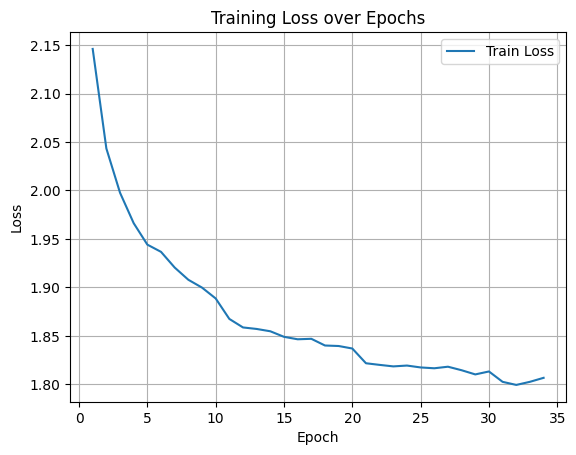

In [6]:
x = list(range(1, len(loss_scores_train) + 1))

plt.figure()
plt.plot(x, loss_scores_train, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

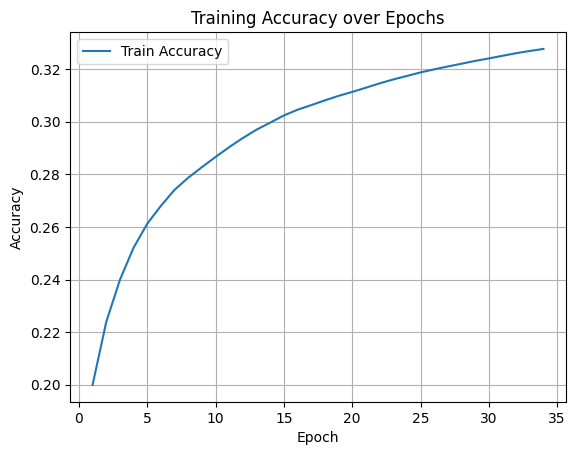

In [7]:
plt.figure()
plt.plot(x, accuracy_scores_train, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
torch.save(model.state_dict(), "bird_classifier_3.pth")

### Experiment 1 - Multihead

baseline is one,  test 2 then 4 then 8

2 heads

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_multihead_2 = BirdClassifier(cnn_state=False, head_count= 2).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multihead_2.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multihead_2 = []
accuracy_scores_train_multihead_2 = []

loss_scores_test_multihead_2 = []
accuracy_scores_test_multihead_2 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multihead_2, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multihead_2, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multihead_2.append(train_acc)
    loss_scores_train_multihead_2.append(train_loss)

    accuracy_scores_test_multihead_2.append(test_acc)
    loss_scores_test_multihead_2.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.08it/s]


Train Acc: 0.2294 | Train Loss: 2.1087 | Test Acc: 0.2452 | Test Loss: 1.9736139482381392

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.87it/s]


Train Acc: 0.2680 | Train Loss: 1.9668 | Test Acc: 0.2732 | Test Loss: 1.9313360395885648

Epoch 3


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.24it/s]


Train Acc: 0.2853 | Train Loss: 1.9132 | Test Acc: 0.2877 | Test Loss: 1.9179053347126966

Epoch 4


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.40it/s]


Train Acc: 0.2956 | Train Loss: 1.8818 | Test Acc: 0.2983 | Test Loss: 1.8510905706963572

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.47it/s]


Train Acc: 0.3046 | Train Loss: 1.8553 | Test Acc: 0.3068 | Test Loss: 1.8033982085532883

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.10it/s]


Train Acc: 0.3126 | Train Loss: 1.8225 | Test Acc: 0.3142 | Test Loss: 1.8267573483136235

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.82it/s]


Train Acc: 0.3189 | Train Loss: 1.8098 | Test Acc: 0.3201 | Test Loss: 1.8112346744861731

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.12it/s]


Train Acc: 0.3245 | Train Loss: 1.7960 | Test Acc: 0.3256 | Test Loss: 1.7991932411583103

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.41it/s]


Train Acc: 0.3293 | Train Loss: 1.7816 | Test Acc: 0.3302 | Test Loss: 1.8260950539387812

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.28it/s]


Train Acc: 0.3337 | Train Loss: 1.7715 | Test Acc: 0.3343 | Test Loss: 1.8091089019970017

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.47it/s]


Train Acc: 0.3373 | Train Loss: 1.7677 | Test Acc: 0.3381 | Test Loss: 1.7449698894202303

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.06it/s]


Train Acc: 0.3407 | Train Loss: 1.7644 | Test Acc: 0.3414 | Test Loss: 1.7654309621473558

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.99it/s]


Train Acc: 0.3438 | Train Loss: 1.7485 | Test Acc: 0.3446 | Test Loss: 1.7186804985513493

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.64it/s]


Train Acc: 0.3470 | Train Loss: 1.7378 | Test Acc: 0.3475 | Test Loss: 1.7501134758903867
No improvement. Early stopping counter: 1/3

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.13it/s]


Train Acc: 0.3496 | Train Loss: 1.7327 | Test Acc: 0.3501 | Test Loss: 1.7315869509768325

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.32it/s]


Train Acc: 0.3521 | Train Loss: 1.7303 | Test Acc: 0.3527 | Test Loss: 1.735285640573826
No improvement. Early stopping counter: 1/3

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.70it/s]


Train Acc: 0.3545 | Train Loss: 1.7276 | Test Acc: 0.3550 | Test Loss: 1.705773002436372

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.69it/s]


Train Acc: 0.3568 | Train Loss: 1.7184 | Test Acc: 0.3572 | Test Loss: 1.7474919695432494
No improvement. Early stopping counter: 1/3

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.54it/s]


Train Acc: 0.3588 | Train Loss: 1.7157 | Test Acc: 0.3594 | Test Loss: 1.6916118835916325

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.13it/s]


Train Acc: 0.3608 | Train Loss: 1.7144 | Test Acc: 0.3613 | Test Loss: 1.7077689519544847
No improvement. Early stopping counter: 1/3

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.74it/s]


Train Acc: 0.3628 | Train Loss: 1.7042 | Test Acc: 0.3632 | Test Loss: 1.6919340933261275

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.16it/s]


Train Acc: 0.3645 | Train Loss: 1.7077 | Test Acc: 0.3649 | Test Loss: 1.6835313897554567
No improvement. Early stopping counter: 1/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.42it/s]


Train Acc: 0.3661 | Train Loss: 1.6984 | Test Acc: 0.3664 | Test Loss: 1.6953626935984814

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.82it/s]


Train Acc: 0.3676 | Train Loss: 1.6942 | Test Acc: 0.3680 | Test Loss: 1.6744469793475405
No improvement. Early stopping counter: 1/3

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.32it/s]


Train Acc: 0.3690 | Train Loss: 1.7015 | Test Acc: 0.3694 | Test Loss: 1.672696050332517
No improvement. Early stopping counter: 2/3

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.68it/s]


Train Acc: 0.3704 | Train Loss: 1.6894 | Test Acc: 0.3708 | Test Loss: 1.6789445276974009

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.97it/s]


Train Acc: 0.3718 | Train Loss: 1.6866 | Test Acc: 0.3720 | Test Loss: 1.6844978218986875
No improvement. Early stopping counter: 1/3

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.12it/s]


Train Acc: 0.3730 | Train Loss: 1.6879 | Test Acc: 0.3732 | Test Loss: 1.6779660408188697
No improvement. Early stopping counter: 2/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.47it/s]


Train Acc: 0.3742 | Train Loss: 1.6869 | Test Acc: 0.3744 | Test Loss: 1.7098598885698384

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.32it/s]


Train Acc: 0.3752 | Train Loss: 1.6801 | Test Acc: 0.3755 | Test Loss: 1.6913984705801723
No improvement. Early stopping counter: 1/3

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.58it/s]


Train Acc: 0.3764 | Train Loss: 1.6770 | Test Acc: 0.3767 | Test Loss: 1.6729031955303788
No improvement. Early stopping counter: 2/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.03it/s]


Train Acc: 0.3775 | Train Loss: 1.6800 | Test Acc: 0.3777 | Test Loss: 1.6712741932901396

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.23it/s]


Train Acc: 0.3785 | Train Loss: 1.6761 | Test Acc: 0.3786 | Test Loss: 1.7125783866765547
No improvement. Early stopping counter: 1/3

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.01it/s]


Train Acc: 0.3794 | Train Loss: 1.6712 | Test Acc: 0.3795 | Test Loss: 1.690087374375791
No improvement. Early stopping counter: 2/3

Epoch 35


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.20it/s]

Train Acc: 0.3802 | Train Loss: 1.6697 | Test Acc: 0.3805 | Test Loss: 1.6624160340043153
No improvement. Early stopping counter: 3/3
Early stopping triggered.


4 heads

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_multihead_4 = BirdClassifier(cnn_state=False, head_count = 4).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multihead_4.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multihead_4 = []
accuracy_scores_train_multihead_4 = []

loss_scores_test_multihead_4 = []
accuracy_scores_test_multihead_4 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multihead_4, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multihead_4, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multihead_4.append(train_acc)
    loss_scores_train_multihead_4.append(train_loss)

    accuracy_scores_test_multihead_4.append(test_acc)
    loss_scores_test_multihead_4.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.92it/s]


Train Acc: 0.2595 | Train Loss: 2.0431 | Test Acc: 0.2704 | Test Loss: 1.9362640956632133

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.60it/s]


Train Acc: 0.2915 | Train Loss: 1.9089 | Test Acc: 0.2969 | Test Loss: 1.843114193604917

Epoch 3


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.79it/s]


Train Acc: 0.3098 | Train Loss: 1.8492 | Test Acc: 0.3130 | Test Loss: 1.8202411577004154

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.60it/s]


Train Acc: 0.3218 | Train Loss: 1.8093 | Test Acc: 0.3239 | Test Loss: 1.831742291547814

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.34it/s]


Train Acc: 0.3312 | Train Loss: 1.7852 | Test Acc: 0.3331 | Test Loss: 1.7546913567043485

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.36it/s]


Train Acc: 0.3384 | Train Loss: 1.7629 | Test Acc: 0.3403 | Test Loss: 1.7152314688883672

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.31it/s]


Train Acc: 0.3451 | Train Loss: 1.7418 | Test Acc: 0.3466 | Test Loss: 1.7256662359043045

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.40it/s]


Train Acc: 0.3507 | Train Loss: 1.7244 | Test Acc: 0.3521 | Test Loss: 1.712647592940298

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.58it/s]


Train Acc: 0.3556 | Train Loss: 1.7131 | Test Acc: 0.3568 | Test Loss: 1.6972615483666764

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.56it/s]


Train Acc: 0.3599 | Train Loss: 1.7019 | Test Acc: 0.3611 | Test Loss: 1.6637468735376995

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.05it/s]


Train Acc: 0.3638 | Train Loss: 1.6904 | Test Acc: 0.3648 | Test Loss: 1.6606654593733703

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.47it/s]


Train Acc: 0.3674 | Train Loss: 1.6829 | Test Acc: 0.3682 | Test Loss: 1.6750502910743765

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.37it/s]


Train Acc: 0.3705 | Train Loss: 1.6791 | Test Acc: 0.3713 | Test Loss: 1.637947779123475

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.82it/s]


Train Acc: 0.3736 | Train Loss: 1.6686 | Test Acc: 0.3744 | Test Loss: 1.629761707215082

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.38it/s]


Train Acc: 0.3764 | Train Loss: 1.6607 | Test Acc: 0.3772 | Test Loss: 1.624064993696148
No improvement. Early stopping counter: 1/3

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.49it/s]


Train Acc: 0.3791 | Train Loss: 1.6566 | Test Acc: 0.3798 | Test Loss: 1.633488647791804

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.39it/s]


Train Acc: 0.3816 | Train Loss: 1.6466 | Test Acc: 0.3820 | Test Loss: 1.6557954987701105
No improvement. Early stopping counter: 1/3

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.94it/s]


Train Acc: 0.3837 | Train Loss: 1.6394 | Test Acc: 0.3843 | Test Loss: 1.602023526924808

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.21it/s]


Train Acc: 0.3858 | Train Loss: 1.6405 | Test Acc: 0.3863 | Test Loss: 1.643773571974566
No improvement. Early stopping counter: 1/3

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.63it/s]


Train Acc: 0.3879 | Train Loss: 1.6296 | Test Acc: 0.3884 | Test Loss: 1.6085256751702757

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.14it/s]


Train Acc: 0.3896 | Train Loss: 1.6297 | Test Acc: 0.3901 | Test Loss: 1.626920834690535
No improvement. Early stopping counter: 1/3

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.03it/s]


Train Acc: 0.3913 | Train Loss: 1.6203 | Test Acc: 0.3918 | Test Loss: 1.5882493679215308

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.70it/s]


Train Acc: 0.3931 | Train Loss: 1.6146 | Test Acc: 0.3936 | Test Loss: 1.5823193456039948
No improvement. Early stopping counter: 1/3

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.75it/s]


Train Acc: 0.3947 | Train Loss: 1.6151 | Test Acc: 0.3951 | Test Loss: 1.5801183942223893

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.57it/s]


Train Acc: 0.3964 | Train Loss: 1.6057 | Test Acc: 0.3968 | Test Loss: 1.5871915549648052
No improvement. Early stopping counter: 1/3

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.22it/s]


Train Acc: 0.3980 | Train Loss: 1.6006 | Test Acc: 0.3984 | Test Loss: 1.586274199745282

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.00it/s]


Train Acc: 0.3995 | Train Loss: 1.5985 | Test Acc: 0.3999 | Test Loss: 1.5793486063172217
No improvement. Early stopping counter: 1/3

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.90it/s]


Train Acc: 0.4011 | Train Loss: 1.5900 | Test Acc: 0.4014 | Test Loss: 1.578190340476782
No improvement. Early stopping counter: 2/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.51it/s]


Train Acc: 0.4025 | Train Loss: 1.5868 | Test Acc: 0.4028 | Test Loss: 1.5754593294494006

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.03it/s]


Train Acc: 0.4039 | Train Loss: 1.5817 | Test Acc: 0.4043 | Test Loss: 1.564076576914106
No improvement. Early stopping counter: 1/3

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.45it/s]


Train Acc: 0.4054 | Train Loss: 1.5794 | Test Acc: 0.4057 | Test Loss: 1.575057568193293
No improvement. Early stopping counter: 2/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.29it/s]


Train Acc: 0.4066 | Train Loss: 1.5772 | Test Acc: 0.4070 | Test Loss: 1.5286394982110887

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.02it/s]


Train Acc: 0.4080 | Train Loss: 1.5752 | Test Acc: 0.4083 | Test Loss: 1.527288140082846
No improvement. Early stopping counter: 1/3

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.72it/s]


Train Acc: 0.4092 | Train Loss: 1.5633 | Test Acc: 0.4096 | Test Loss: 1.5411193289724336
No improvement. Early stopping counter: 2/3

Epoch 35


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.11it/s]


Train Acc: 0.4105 | Train Loss: 1.5635 | Test Acc: 0.4108 | Test Loss: 1.5452864226840792

Epoch 36


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.32it/s]


Train Acc: 0.4117 | Train Loss: 1.5600 | Test Acc: 0.4120 | Test Loss: 1.5554205252199758
No improvement. Early stopping counter: 1/3

Epoch 37


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.09it/s]


Train Acc: 0.4128 | Train Loss: 1.5589 | Test Acc: 0.4131 | Test Loss: 1.5670965342294603
No improvement. Early stopping counter: 2/3

Epoch 38


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.32it/s]


Train Acc: 0.4140 | Train Loss: 1.5516 | Test Acc: 0.4143 | Test Loss: 1.5307976007461548

Epoch 39


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.93it/s]


Train Acc: 0.4151 | Train Loss: 1.5495 | Test Acc: 0.4154 | Test Loss: 1.5404855434586402
No improvement. Early stopping counter: 1/3

Epoch 40


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.55it/s]


Train Acc: 0.4162 | Train Loss: 1.5480 | Test Acc: 0.4165 | Test Loss: 1.5314647267464878
No improvement. Early stopping counter: 2/3

Epoch 41


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.94it/s]


Train Acc: 0.4173 | Train Loss: 1.5442 | Test Acc: 0.4175 | Test Loss: 1.5442534003938948

Epoch 42


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.90it/s]


Train Acc: 0.4183 | Train Loss: 1.5431 | Test Acc: 0.4185 | Test Loss: 1.5070850119298818
No improvement. Early stopping counter: 1/3

Epoch 43


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.35it/s]


Train Acc: 0.4193 | Train Loss: 1.5430 | Test Acc: 0.4196 | Test Loss: 1.516853659331393
No improvement. Early stopping counter: 2/3

Epoch 44


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.09it/s]


Train Acc: 0.4203 | Train Loss: 1.5360 | Test Acc: 0.4205 | Test Loss: 1.5301619346449975

Epoch 45


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.62it/s]


Train Acc: 0.4212 | Train Loss: 1.5358 | Test Acc: 0.4214 | Test Loss: 1.5234094906826408
No improvement. Early stopping counter: 1/3

Epoch 46


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.96it/s]


Train Acc: 0.4221 | Train Loss: 1.5320 | Test Acc: 0.4223 | Test Loss: 1.5227145191763534
No improvement. Early stopping counter: 2/3

Epoch 47


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.23it/s]

Train Acc: 0.4230 | Train Loss: 1.5324 | Test Acc: 0.4233 | Test Loss: 1.5139153360509547
No improvement. Early stopping counter: 3/3
Early stopping triggered.


8 head

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_multihead_8 = BirdClassifier(cnn_state=False, head_count = 8).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multihead_8.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multihead_8 = []
accuracy_scores_train_multihead_8 = []

loss_scores_test_multihead_8 = []
accuracy_scores_test_multihead_8 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multihead_8, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multihead_8, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multihead_8.append(train_acc)
    loss_scores_train_multihead_8.append(train_loss)

    accuracy_scores_test_multihead_8.append(test_acc)
    loss_scores_test_multihead_8.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TRAINIGN:   0%|          | 0/587 [00:00<?, ?it/s]

TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.87it/s]


Train Acc: 0.2782 | Train Loss: 2.0041 | Test Acc: 0.2929 | Test Loss: 1.8376840539530022

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.62it/s]


Train Acc: 0.3150 | Train Loss: 1.8494 | Test Acc: 0.3201 | Test Loss: 1.8290764263698034

Epoch 3


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.32it/s]


Train Acc: 0.3336 | Train Loss: 1.7898 | Test Acc: 0.3360 | Test Loss: 1.8054463076753682

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.71it/s]


Train Acc: 0.3451 | Train Loss: 1.7551 | Test Acc: 0.3475 | Test Loss: 1.729558809273908

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.10it/s]


Train Acc: 0.3553 | Train Loss: 1.7220 | Test Acc: 0.3577 | Test Loss: 1.6680301127790593

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.96it/s]


Train Acc: 0.3633 | Train Loss: 1.6983 | Test Acc: 0.3648 | Test Loss: 1.6880966003249291

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.01it/s]


Train Acc: 0.3699 | Train Loss: 1.6782 | Test Acc: 0.3712 | Test Loss: 1.7034949412962206

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.01it/s]


Train Acc: 0.3760 | Train Loss: 1.6608 | Test Acc: 0.3774 | Test Loss: 1.6191902387709844

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.99it/s]


Train Acc: 0.3814 | Train Loss: 1.6443 | Test Acc: 0.3825 | Test Loss: 1.6293868175169237

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.30it/s]


Train Acc: 0.3864 | Train Loss: 1.6340 | Test Acc: 0.3874 | Test Loss: 1.6304285274881896

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.08it/s]


Train Acc: 0.3907 | Train Loss: 1.6217 | Test Acc: 0.3918 | Test Loss: 1.5962930552813472

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.61it/s]


Train Acc: 0.3946 | Train Loss: 1.6138 | Test Acc: 0.3955 | Test Loss: 1.588264248809036

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.84it/s]


Train Acc: 0.3982 | Train Loss: 1.6002 | Test Acc: 0.3992 | Test Loss: 1.5514932660018506

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.21it/s]


Train Acc: 0.4016 | Train Loss: 1.5899 | Test Acc: 0.4024 | Test Loss: 1.574568596015982

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.77it/s]


Train Acc: 0.4047 | Train Loss: 1.5829 | Test Acc: 0.4055 | Test Loss: 1.566573681474543

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.20it/s]


Train Acc: 0.4077 | Train Loss: 1.5736 | Test Acc: 0.4082 | Test Loss: 1.61675387418189
No improvement. Early stopping counter: 1/3

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.89it/s]


Train Acc: 0.4102 | Train Loss: 1.5650 | Test Acc: 0.4109 | Test Loss: 1.5355897306584987

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.89it/s]


Train Acc: 0.4127 | Train Loss: 1.5627 | Test Acc: 0.4133 | Test Loss: 1.5583392195150154
No improvement. Early stopping counter: 1/3

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.48it/s]


Train Acc: 0.4152 | Train Loss: 1.5538 | Test Acc: 0.4159 | Test Loss: 1.5358113520810392

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.64it/s]


Train Acc: 0.4175 | Train Loss: 1.5449 | Test Acc: 0.4180 | Test Loss: 1.5281595218749273
No improvement. Early stopping counter: 1/3

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.43it/s]


Train Acc: 0.4197 | Train Loss: 1.5404 | Test Acc: 0.4202 | Test Loss: 1.5395702780509481

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.95it/s]


Train Acc: 0.4218 | Train Loss: 1.5339 | Test Acc: 0.4223 | Test Loss: 1.497181611807168
No improvement. Early stopping counter: 1/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.81it/s]


Train Acc: 0.4240 | Train Loss: 1.5242 | Test Acc: 0.4244 | Test Loss: 1.5597695509592693

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.01it/s]


Train Acc: 0.4259 | Train Loss: 1.5216 | Test Acc: 0.4262 | Test Loss: 1.551411999326174
No improvement. Early stopping counter: 1/3

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.44it/s]


Train Acc: 0.4277 | Train Loss: 1.5172 | Test Acc: 0.4281 | Test Loss: 1.514462638874443

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.87it/s]


Train Acc: 0.4295 | Train Loss: 1.5120 | Test Acc: 0.4299 | Test Loss: 1.5133031501251013
No improvement. Early stopping counter: 1/3

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.55it/s]


Train Acc: 0.4311 | Train Loss: 1.5083 | Test Acc: 0.4315 | Test Loss: 1.501851782506826

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.29it/s]


Train Acc: 0.4328 | Train Loss: 1.5019 | Test Acc: 0.4332 | Test Loss: 1.4845954139216417
No improvement. Early stopping counter: 1/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.80it/s]


Train Acc: 0.4345 | Train Loss: 1.4977 | Test Acc: 0.4348 | Test Loss: 1.4881826744598596

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.68it/s]


Train Acc: 0.4360 | Train Loss: 1.4943 | Test Acc: 0.4364 | Test Loss: 1.4810815490021998
No improvement. Early stopping counter: 1/3

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.70it/s]


Train Acc: 0.4375 | Train Loss: 1.4928 | Test Acc: 0.4377 | Test Loss: 1.521694033324313
No improvement. Early stopping counter: 2/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.33it/s]


Train Acc: 0.4388 | Train Loss: 1.4878 | Test Acc: 0.4391 | Test Loss: 1.5000267847865618

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.64it/s]


Train Acc: 0.4402 | Train Loss: 1.4823 | Test Acc: 0.4405 | Test Loss: 1.472038663163477
No improvement. Early stopping counter: 1/3

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.65it/s]


Train Acc: 0.4416 | Train Loss: 1.4719 | Test Acc: 0.4419 | Test Loss: 1.4789586399688202
No improvement. Early stopping counter: 2/3

Epoch 35


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.78it/s]


Train Acc: 0.4429 | Train Loss: 1.4718 | Test Acc: 0.4432 | Test Loss: 1.4668763259641167

Epoch 36


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.29it/s]


Train Acc: 0.4441 | Train Loss: 1.4710 | Test Acc: 0.4444 | Test Loss: 1.4557108822323026
No improvement. Early stopping counter: 1/3

Epoch 37


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.51it/s]


Train Acc: 0.4454 | Train Loss: 1.4652 | Test Acc: 0.4457 | Test Loss: 1.4532004943510302
No improvement. Early stopping counter: 2/3

Epoch 38


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.60it/s]


Train Acc: 0.4466 | Train Loss: 1.4627 | Test Acc: 0.4469 | Test Loss: 1.472671080608757

Epoch 39


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.63it/s]


Train Acc: 0.4477 | Train Loss: 1.4664 | Test Acc: 0.4480 | Test Loss: 1.500238790804026
No improvement. Early stopping counter: 1/3

Epoch 40


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.89it/s]


Train Acc: 0.4488 | Train Loss: 1.4628 | Test Acc: 0.4491 | Test Loss: 1.4764470105268517
No improvement. Early stopping counter: 2/3

Epoch 41


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.00it/s]


Train Acc: 0.4499 | Train Loss: 1.4569 | Test Acc: 0.4501 | Test Loss: 1.4443031241293667

Epoch 42


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.58it/s]


Train Acc: 0.4509 | Train Loss: 1.4549 | Test Acc: 0.4511 | Test Loss: 1.4721062969999248
No improvement. Early stopping counter: 1/3

Epoch 43


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.44it/s]


Train Acc: 0.4520 | Train Loss: 1.4530 | Test Acc: 0.4521 | Test Loss: 1.4766628442167424
No improvement. Early stopping counter: 2/3

Epoch 44


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.72it/s]


Train Acc: 0.4529 | Train Loss: 1.4481 | Test Acc: 0.4531 | Test Loss: 1.4589665236116267

Epoch 45


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.97it/s]


Train Acc: 0.4539 | Train Loss: 1.4465 | Test Acc: 0.4541 | Test Loss: 1.441009406329823
No improvement. Early stopping counter: 1/3

Epoch 46


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.09it/s]


Train Acc: 0.4549 | Train Loss: 1.4407 | Test Acc: 0.4551 | Test Loss: 1.44783985655324
No improvement. Early stopping counter: 2/3

Epoch 47


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.52it/s]

Train Acc: 0.4558 | Train Loss: 1.4433 | Test Acc: 0.4560 | Test Loss: 1.464443291936602
No improvement. Early stopping counter: 3/3
Early stopping triggered.


### Increaseing Layers
2 then 4 then 8

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_multilayer_2 = BirdClassifier(cnn_state=False, dim= 256, layer_count=2, head_count = 1).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multilayer_2.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multilayer_2 = []
accuracy_scores_train_multilayer_2 = []

loss_scores_test_multilayer_2 = []
accuracy_scores_test_multilayer_2 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multilayer_2, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multilayer_2, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multilayer_2.append(train_acc)
    loss_scores_train_multilayer_2.append(train_loss)

    accuracy_scores_test_multilayer_2.append(test_acc)
    loss_scores_test_multilayer_2.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TRAINIGN:   0%|          | 0/587 [00:00<?, ?it/s]

TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.82it/s]


Train Acc: 0.2582 | Train Loss: 2.0444 | Test Acc: 0.2680 | Test Loss: 1.9556572469724278

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.88it/s]


Train Acc: 0.2916 | Train Loss: 1.9000 | Test Acc: 0.2949 | Test Loss: 1.9029295663444363

Epoch 3


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.05it/s]


Train Acc: 0.3089 | Train Loss: 1.8318 | Test Acc: 0.3112 | Test Loss: 1.8761470066446837

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.64it/s]


Train Acc: 0.3223 | Train Loss: 1.7845 | Test Acc: 0.3257 | Test Loss: 1.760538212296103

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.47it/s]


Train Acc: 0.3340 | Train Loss: 1.7549 | Test Acc: 0.3360 | Test Loss: 1.7704130654432335

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.20it/s]


Train Acc: 0.3427 | Train Loss: 1.7301 | Test Acc: 0.3445 | Test Loss: 1.7614409688378678

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.31it/s]


Train Acc: 0.3501 | Train Loss: 1.7085 | Test Acc: 0.3519 | Test Loss: 1.7045003094640718

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.47it/s]


Train Acc: 0.3569 | Train Loss: 1.6969 | Test Acc: 0.3580 | Test Loss: 1.7314529597353774

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.47it/s]


Train Acc: 0.3620 | Train Loss: 1.6853 | Test Acc: 0.3633 | Test Loss: 1.6983623107274373

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.40it/s]


Train Acc: 0.3669 | Train Loss: 1.6728 | Test Acc: 0.3682 | Test Loss: 1.6461967294718944

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.76it/s]


Train Acc: 0.3716 | Train Loss: 1.6599 | Test Acc: 0.3725 | Test Loss: 1.6403618012966752

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.81it/s]


Train Acc: 0.3757 | Train Loss: 1.6490 | Test Acc: 0.3762 | Test Loss: 1.7503932592820148

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.21it/s]


Train Acc: 0.3791 | Train Loss: 1.6357 | Test Acc: 0.3797 | Test Loss: 1.7076896745331434

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.74it/s]


Train Acc: 0.3822 | Train Loss: 1.6294 | Test Acc: 0.3830 | Test Loss: 1.6218093260615862

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.37it/s]


Train Acc: 0.3853 | Train Loss: 1.6237 | Test Acc: 0.3860 | Test Loss: 1.6158181185625038

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.92it/s]


Train Acc: 0.3884 | Train Loss: 1.6036 | Test Acc: 0.3890 | Test Loss: 1.6436840441762184
No improvement. Early stopping counter: 1/3

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.49it/s]


Train Acc: 0.3912 | Train Loss: 1.6047 | Test Acc: 0.3917 | Test Loss: 1.6177426884774448

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.60it/s]


Train Acc: 0.3936 | Train Loss: 1.5989 | Test Acc: 0.3941 | Test Loss: 1.6139903863271077
No improvement. Early stopping counter: 1/3

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.48it/s]


Train Acc: 0.3959 | Train Loss: 1.5900 | Test Acc: 0.3964 | Test Loss: 1.623449073356836

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.38it/s]


Train Acc: 0.3981 | Train Loss: 1.5861 | Test Acc: 0.3986 | Test Loss: 1.6336041770013823
No improvement. Early stopping counter: 1/3

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.96it/s]


Train Acc: 0.4003 | Train Loss: 1.5792 | Test Acc: 0.4007 | Test Loss: 1.6395445137607807

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.92it/s]


Train Acc: 0.4022 | Train Loss: 1.5759 | Test Acc: 0.4027 | Test Loss: 1.5738959596270607
No improvement. Early stopping counter: 1/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.61it/s]


Train Acc: 0.4043 | Train Loss: 1.5709 | Test Acc: 0.4046 | Test Loss: 1.6194726593640385

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.52it/s]


Train Acc: 0.4061 | Train Loss: 1.5624 | Test Acc: 0.4066 | Test Loss: 1.575782475017366
No improvement. Early stopping counter: 1/3

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.17it/s]


Train Acc: 0.4080 | Train Loss: 1.5517 | Test Acc: 0.4084 | Test Loss: 1.5918265256751962

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.53it/s]


Train Acc: 0.4099 | Train Loss: 1.5439 | Test Acc: 0.4103 | Test Loss: 1.6188388714174025
No improvement. Early stopping counter: 1/3

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.39it/s]


Train Acc: 0.4116 | Train Loss: 1.5409 | Test Acc: 0.4119 | Test Loss: 1.598564902941386

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.82it/s]


Train Acc: 0.4132 | Train Loss: 1.5351 | Test Acc: 0.4136 | Test Loss: 1.5499642203454258
No improvement. Early stopping counter: 1/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.41it/s]


Train Acc: 0.4149 | Train Loss: 1.5350 | Test Acc: 0.4152 | Test Loss: 1.6266146436029552

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.21it/s]


Train Acc: 0.4164 | Train Loss: 1.5290 | Test Acc: 0.4167 | Test Loss: 1.5447319819002736
No improvement. Early stopping counter: 1/3

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.72it/s]


Train Acc: 0.4180 | Train Loss: 1.5195 | Test Acc: 0.4184 | Test Loss: 1.5309709853866473

Epoch 32


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.99it/s]


Train Acc: 0.4196 | Train Loss: 1.5160 | Test Acc: 0.4199 | Test Loss: 1.5327078712229827
No improvement. Early stopping counter: 1/3

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.40it/s]


Train Acc: 0.4211 | Train Loss: 1.5127 | Test Acc: 0.4214 | Test Loss: 1.542065213326694

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.84it/s]


Train Acc: 0.4226 | Train Loss: 1.5044 | Test Acc: 0.4229 | Test Loss: 1.5195183397150365
No improvement. Early stopping counter: 1/3

Epoch 35


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.42it/s]


Train Acc: 0.4240 | Train Loss: 1.4993 | Test Acc: 0.4243 | Test Loss: 1.5295556053823354
No improvement. Early stopping counter: 2/3

Epoch 36


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.22it/s]


Train Acc: 0.4255 | Train Loss: 1.4911 | Test Acc: 0.4258 | Test Loss: 1.5251337241153329

Epoch 37


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.01it/s]


Train Acc: 0.4269 | Train Loss: 1.4901 | Test Acc: 0.4272 | Test Loss: 1.4954029151371546
No improvement. Early stopping counter: 1/3

Epoch 38


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.76it/s]


Train Acc: 0.4283 | Train Loss: 1.4855 | Test Acc: 0.4286 | Test Loss: 1.509473299493595
No improvement. Early stopping counter: 2/3

Epoch 39


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.91it/s]


Train Acc: 0.4297 | Train Loss: 1.4831 | Test Acc: 0.4300 | Test Loss: 1.5123391508245143

Epoch 40


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.24it/s]


Train Acc: 0.4310 | Train Loss: 1.4813 | Test Acc: 0.4312 | Test Loss: 1.5685210665877984
No improvement. Early stopping counter: 1/3

Epoch 41


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.09it/s]


Train Acc: 0.4322 | Train Loss: 1.4734 | Test Acc: 0.4324 | Test Loss: 1.5327473254430861
No improvement. Early stopping counter: 2/3

Epoch 42


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.23it/s]


Train Acc: 0.4334 | Train Loss: 1.4653 | Test Acc: 0.4336 | Test Loss: 1.552190714952897

Epoch 43


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.17it/s]


Train Acc: 0.4345 | Train Loss: 1.4643 | Test Acc: 0.4347 | Test Loss: 1.52486041127419
No improvement. Early stopping counter: 1/3

Epoch 44


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.74it/s]


Train Acc: 0.4357 | Train Loss: 1.4585 | Test Acc: 0.4359 | Test Loss: 1.5219612981186432
No improvement. Early stopping counter: 2/3

Epoch 45


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.43it/s]


Train Acc: 0.4369 | Train Loss: 1.4560 | Test Acc: 0.4371 | Test Loss: 1.4794073267047907

Epoch 46


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.17it/s]


Train Acc: 0.4381 | Train Loss: 1.4470 | Test Acc: 0.4383 | Test Loss: 1.5238165303963382
No improvement. Early stopping counter: 1/3

Epoch 47


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.48it/s]


Train Acc: 0.4391 | Train Loss: 1.4497 | Test Acc: 0.4394 | Test Loss: 1.448675174291442
No improvement. Early stopping counter: 2/3

Epoch 48


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.46it/s]


Train Acc: 0.4402 | Train Loss: 1.4440 | Test Acc: 0.4405 | Test Loss: 1.4668330108227372

Epoch 49


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.02it/s]


Train Acc: 0.4413 | Train Loss: 1.4372 | Test Acc: 0.4415 | Test Loss: 1.4975914233395842
No improvement. Early stopping counter: 1/3

Epoch 50


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.00it/s]


Train Acc: 0.4424 | Train Loss: 1.4360 | Test Acc: 0.4425 | Test Loss: 1.5649053069199024
No improvement. Early stopping counter: 2/3

Epoch 51


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.92it/s]


Train Acc: 0.4434 | Train Loss: 1.4297 | Test Acc: 0.4436 | Test Loss: 1.4958235666054447

Epoch 52


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.45it/s]


Train Acc: 0.4444 | Train Loss: 1.4294 | Test Acc: 0.4446 | Test Loss: 1.4761561674325645
No improvement. Early stopping counter: 1/3

Epoch 53


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.37it/s]


Train Acc: 0.4454 | Train Loss: 1.4244 | Test Acc: 0.4456 | Test Loss: 1.4874435371282149
No improvement. Early stopping counter: 2/3

Epoch 54


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.36it/s]


Train Acc: 0.4465 | Train Loss: 1.4233 | Test Acc: 0.4467 | Test Loss: 1.4994621625562914

Epoch 55


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.52it/s]


Train Acc: 0.4475 | Train Loss: 1.4207 | Test Acc: 0.4477 | Test Loss: 1.4692258169861878
No improvement. Early stopping counter: 1/3

Epoch 56


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.34it/s]


Train Acc: 0.4485 | Train Loss: 1.4180 | Test Acc: 0.4487 | Test Loss: 1.4922307218824113
No improvement. Early stopping counter: 2/3

Epoch 57


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.32it/s]

Train Acc: 0.4495 | Train Loss: 1.4142 | Test Acc: 0.4496 | Test Loss: 1.4959788298120305
No improvement. Early stopping counter: 3/3
Early stopping triggered.


4 layers

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_multilayer_4 = BirdClassifier(cnn_state=False, dim= 256, layer_count=4, head_count = 1).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multilayer_4.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multilayer_4 = []
accuracy_scores_train_multilayer_4 = []

loss_scores_test_multilayer_4 = []
accuracy_scores_test_multilayer_4 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multilayer_4, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multilayer_4, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multilayer_4.append(train_acc)
    loss_scores_train_multilayer_4.append(train_loss)

    accuracy_scores_test_multilayer_4.append(test_acc)
    loss_scores_test_multilayer_4.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.53it/s]


Train Acc: 0.2690 | Train Loss: 2.0146 | Test Acc: 0.2840 | Test Loss: 1.8448884024911998

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.86it/s]


Train Acc: 0.3083 | Train Loss: 1.8535 | Test Acc: 0.3138 | Test Loss: 1.7962800450876457

Epoch 3


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.64it/s]


Train Acc: 0.3282 | Train Loss: 1.7859 | Test Acc: 0.3318 | Test Loss: 1.7430940096070167

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.02it/s]


Train Acc: 0.3422 | Train Loss: 1.7451 | Test Acc: 0.3441 | Test Loss: 1.7868063855333394

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.20it/s]


Train Acc: 0.3521 | Train Loss: 1.7114 | Test Acc: 0.3541 | Test Loss: 1.7164161229620174

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.07it/s]


Train Acc: 0.3609 | Train Loss: 1.6819 | Test Acc: 0.3625 | Test Loss: 1.753816078309299

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.62it/s]


Train Acc: 0.3682 | Train Loss: 1.6606 | Test Acc: 0.3698 | Test Loss: 1.6520430474054246

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.11it/s]


Train Acc: 0.3751 | Train Loss: 1.6381 | Test Acc: 0.3767 | Test Loss: 1.6413907550630116

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.01it/s]


Train Acc: 0.3817 | Train Loss: 1.6119 | Test Acc: 0.3832 | Test Loss: 1.5783440312560724

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.53it/s]


Train Acc: 0.3876 | Train Loss: 1.5921 | Test Acc: 0.3888 | Test Loss: 1.610243092588827

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.37it/s]


Train Acc: 0.3931 | Train Loss: 1.5717 | Test Acc: 0.3944 | Test Loss: 1.5373573846557513

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.60it/s]


Train Acc: 0.3985 | Train Loss: 1.5563 | Test Acc: 0.3995 | Test Loss: 1.5559056899985488

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.07it/s]


Train Acc: 0.4033 | Train Loss: 1.5367 | Test Acc: 0.4043 | Test Loss: 1.535315726890045

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.00it/s]


Train Acc: 0.4080 | Train Loss: 1.5136 | Test Acc: 0.4089 | Test Loss: 1.5674011034219444

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.84it/s]


Train Acc: 0.4123 | Train Loss: 1.5032 | Test Acc: 0.4131 | Test Loss: 1.5589630676775563

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.05it/s]


Train Acc: 0.4163 | Train Loss: 1.4859 | Test Acc: 0.4173 | Test Loss: 1.4823604481560844

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.82it/s]


Train Acc: 0.4204 | Train Loss: 1.4763 | Test Acc: 0.4211 | Test Loss: 1.601205091898133

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.17it/s]


Train Acc: 0.4241 | Train Loss: 1.4582 | Test Acc: 0.4249 | Test Loss: 1.501180428225978

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.97it/s]


Train Acc: 0.4279 | Train Loss: 1.4407 | Test Acc: 0.4285 | Test Loss: 1.560676503343647

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.09it/s]


Train Acc: 0.4313 | Train Loss: 1.4336 | Test Acc: 0.4322 | Test Loss: 1.4566113681209332

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.39it/s]


Train Acc: 0.4351 | Train Loss: 1.4134 | Test Acc: 0.4357 | Test Loss: 1.490702635576936

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.30it/s]


Train Acc: 0.4384 | Train Loss: 1.4046 | Test Acc: 0.4391 | Test Loss: 1.4261985709067104

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.94it/s]


Train Acc: 0.4418 | Train Loss: 1.3884 | Test Acc: 0.4424 | Test Loss: 1.4449770677657354

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.34it/s]


Train Acc: 0.4450 | Train Loss: 1.3750 | Test Acc: 0.4455 | Test Loss: 1.4681685546628471

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.95it/s]


Train Acc: 0.4481 | Train Loss: 1.3678 | Test Acc: 0.4486 | Test Loss: 1.4496640283234266

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.06it/s]


Train Acc: 0.4510 | Train Loss: 1.3612 | Test Acc: 0.4515 | Test Loss: 1.438807417746304
No improvement. Early stopping counter: 1/3

Epoch 27


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.81it/s]


Train Acc: 0.4539 | Train Loss: 1.3440 | Test Acc: 0.4545 | Test Loss: 1.410063850636385

Epoch 28


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.84it/s]


Train Acc: 0.4568 | Train Loss: 1.3356 | Test Acc: 0.4573 | Test Loss: 1.4130532336072856
No improvement. Early stopping counter: 1/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.98it/s]


Train Acc: 0.4596 | Train Loss: 1.3266 | Test Acc: 0.4601 | Test Loss: 1.3816759136258339

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.42it/s]


Train Acc: 0.4623 | Train Loss: 1.3152 | Test Acc: 0.4627 | Test Loss: 1.4332294780380872
No improvement. Early stopping counter: 1/3

Epoch 31


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.07it/s]


Train Acc: 0.4649 | Train Loss: 1.3081 | Test Acc: 0.4653 | Test Loss: 1.395164703025299

Epoch 32


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.54it/s]


Train Acc: 0.4675 | Train Loss: 1.2997 | Test Acc: 0.4680 | Test Loss: 1.3789855168790233
No improvement. Early stopping counter: 1/3

Epoch 33


TESTING: 100%|██████████| 147/147 [00:05<00:00, 26.09it/s]


Train Acc: 0.4700 | Train Loss: 1.2894 | Test Acc: 0.4705 | Test Loss: 1.3472701862555783

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.72it/s]


Train Acc: 0.4725 | Train Loss: 1.2811 | Test Acc: 0.4730 | Test Loss: 1.3603373259103217
No improvement. Early stopping counter: 1/3

Epoch 35


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.22it/s]


Train Acc: 0.4749 | Train Loss: 1.2742 | Test Acc: 0.4753 | Test Loss: 1.4050693734973467

Epoch 36


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.24it/s]


Train Acc: 0.4772 | Train Loss: 1.2613 | Test Acc: 0.4775 | Test Loss: 1.4102716397266
No improvement. Early stopping counter: 1/3

Epoch 37


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.93it/s]


Train Acc: 0.4794 | Train Loss: 1.2529 | Test Acc: 0.4798 | Test Loss: 1.3451286039384855

Epoch 38


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.98it/s]


Train Acc: 0.4816 | Train Loss: 1.2441 | Test Acc: 0.4821 | Test Loss: 1.3253668639935603
No improvement. Early stopping counter: 1/3

Epoch 39


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.45it/s]


Train Acc: 0.4839 | Train Loss: 1.2346 | Test Acc: 0.4842 | Test Loss: 1.3904964644081739

Epoch 40


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.37it/s]


Train Acc: 0.4860 | Train Loss: 1.2331 | Test Acc: 0.4864 | Test Loss: 1.3681372570342758
No improvement. Early stopping counter: 1/3

Epoch 41


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.78it/s]


Train Acc: 0.4881 | Train Loss: 1.2258 | Test Acc: 0.4885 | Test Loss: 1.3190745257195973

Epoch 42


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.08it/s]


Train Acc: 0.4902 | Train Loss: 1.2172 | Test Acc: 0.4905 | Test Loss: 1.3136463513990648
No improvement. Early stopping counter: 1/3

Epoch 43


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.16it/s]


Train Acc: 0.4922 | Train Loss: 1.2069 | Test Acc: 0.4926 | Test Loss: 1.3155285582250478

Epoch 44


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.03it/s]


Train Acc: 0.4942 | Train Loss: 1.2074 | Test Acc: 0.4946 | Test Loss: 1.2875590612288235
No improvement. Early stopping counter: 1/3

Epoch 45


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.25it/s]


Train Acc: 0.4961 | Train Loss: 1.1994 | Test Acc: 0.4965 | Test Loss: 1.2947454359255681

Epoch 46


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.54it/s]


Train Acc: 0.4981 | Train Loss: 1.1849 | Test Acc: 0.4985 | Test Loss: 1.2758692125884854
No improvement. Early stopping counter: 1/3

Epoch 47


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.22it/s]


Train Acc: 0.5000 | Train Loss: 1.1848 | Test Acc: 0.5003 | Test Loss: 1.317072567080154

Epoch 48


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.68it/s]


Train Acc: 0.5018 | Train Loss: 1.1814 | Test Acc: 0.5022 | Test Loss: 1.3189718662476053
No improvement. Early stopping counter: 1/3

Epoch 49


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.80it/s]


Train Acc: 0.5036 | Train Loss: 1.1790 | Test Acc: 0.5038 | Test Loss: 1.4082560008074962

Epoch 50


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.84it/s]


Train Acc: 0.5053 | Train Loss: 1.1661 | Test Acc: 0.5056 | Test Loss: 1.3063448095808223
No improvement. Early stopping counter: 1/3

Epoch 51


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.03it/s]


Train Acc: 0.5071 | Train Loss: 1.1654 | Test Acc: 0.5074 | Test Loss: 1.2562043228927924

Epoch 52


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.64it/s]


Train Acc: 0.5088 | Train Loss: 1.1547 | Test Acc: 0.5091 | Test Loss: 1.240522324633436
No improvement. Early stopping counter: 1/3

Epoch 53


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.34it/s]


Train Acc: 0.5105 | Train Loss: 1.1470 | Test Acc: 0.5108 | Test Loss: 1.2656504503723716

Epoch 54


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.90it/s]


Train Acc: 0.5122 | Train Loss: 1.1434 | Test Acc: 0.5125 | Test Loss: 1.2594000924201239
No improvement. Early stopping counter: 1/3

Epoch 55


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.49it/s]


Train Acc: 0.5139 | Train Loss: 1.1423 | Test Acc: 0.5141 | Test Loss: 1.2282183198701768

Epoch 56


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.88it/s]


Train Acc: 0.5155 | Train Loss: 1.1312 | Test Acc: 0.5157 | Test Loss: 1.3031811418176509
No improvement. Early stopping counter: 1/3

Epoch 57


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.61it/s]


Train Acc: 0.5171 | Train Loss: 1.1262 | Test Acc: 0.5173 | Test Loss: 1.2468703672999428

Epoch 58


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.51it/s]


Train Acc: 0.5186 | Train Loss: 1.1238 | Test Acc: 0.5188 | Test Loss: 1.3537516326320416
No improvement. Early stopping counter: 1/3

Epoch 59


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.53it/s]


Train Acc: 0.5201 | Train Loss: 1.1136 | Test Acc: 0.5203 | Test Loss: 1.268133637856464
No improvement. Early stopping counter: 2/3

Epoch 60


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.83it/s]


Train Acc: 0.5216 | Train Loss: 1.1108 | Test Acc: 0.5218 | Test Loss: 1.2436442071077776

Epoch 61


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.13it/s]


Train Acc: 0.5231 | Train Loss: 1.1075 | Test Acc: 0.5233 | Test Loss: 1.2127080624606335
No improvement. Early stopping counter: 1/3

Epoch 62


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.29it/s]


Train Acc: 0.5245 | Train Loss: 1.1050 | Test Acc: 0.5247 | Test Loss: 1.2692996137807158
No improvement. Early stopping counter: 2/3

Epoch 63


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.58it/s]


Train Acc: 0.5259 | Train Loss: 1.0947 | Test Acc: 0.5261 | Test Loss: 1.3380639111103654

Epoch 64


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.27it/s]


Train Acc: 0.5273 | Train Loss: 1.0894 | Test Acc: 0.5275 | Test Loss: 1.2144947781854747
No improvement. Early stopping counter: 1/3

Epoch 65


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.93it/s]


Train Acc: 0.5287 | Train Loss: 1.0898 | Test Acc: 0.5289 | Test Loss: 1.2215997698355694
No improvement. Early stopping counter: 2/3

Epoch 66


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.71it/s]


Train Acc: 0.5301 | Train Loss: 1.0774 | Test Acc: 0.5303 | Test Loss: 1.2304644329207284

Epoch 67


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.69it/s]


Train Acc: 0.5315 | Train Loss: 1.0727 | Test Acc: 0.5317 | Test Loss: 1.2294419667347758
No improvement. Early stopping counter: 1/3

Epoch 68


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.26it/s]


Train Acc: 0.5329 | Train Loss: 1.0716 | Test Acc: 0.5331 | Test Loss: 1.209237939646455
No improvement. Early stopping counter: 2/3

Epoch 69


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.34it/s]


Train Acc: 0.5342 | Train Loss: 1.0708 | Test Acc: 0.5344 | Test Loss: 1.1981178015267768

Epoch 70


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.33it/s]


Train Acc: 0.5355 | Train Loss: 1.0649 | Test Acc: 0.5357 | Test Loss: 1.2241459087449678
No improvement. Early stopping counter: 1/3

Epoch 71


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.38it/s]


Train Acc: 0.5368 | Train Loss: 1.0605 | Test Acc: 0.5370 | Test Loss: 1.1929603985377721
No improvement. Early stopping counter: 2/3

Epoch 72


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.51it/s]


Train Acc: 0.5381 | Train Loss: 1.0523 | Test Acc: 0.5382 | Test Loss: 1.3215191173715657

Epoch 73


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.74it/s]


Train Acc: 0.5392 | Train Loss: 1.0567 | Test Acc: 0.5394 | Test Loss: 1.2164646849340321
No improvement. Early stopping counter: 1/3

Epoch 74


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.07it/s]


Train Acc: 0.5405 | Train Loss: 1.0496 | Test Acc: 0.5406 | Test Loss: 1.2495470687645633
No improvement. Early stopping counter: 2/3

Epoch 75


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.59it/s]


Train Acc: 0.5416 | Train Loss: 1.0447 | Test Acc: 0.5418 | Test Loss: 1.209209404429611

Epoch 76


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.75it/s]


Train Acc: 0.5429 | Train Loss: 1.0351 | Test Acc: 0.5430 | Test Loss: 1.2470355070367152
No improvement. Early stopping counter: 1/3

Epoch 77


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.82it/s]


Train Acc: 0.5441 | Train Loss: 1.0316 | Test Acc: 0.5443 | Test Loss: 1.2029163537382268
No improvement. Early stopping counter: 2/3

Epoch 78


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.00it/s]


Train Acc: 0.5453 | Train Loss: 1.0255 | Test Acc: 0.5455 | Test Loss: 1.198672404500092

Epoch 79


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.39it/s]


Train Acc: 0.5465 | Train Loss: 1.0231 | Test Acc: 0.5466 | Test Loss: 1.197078901083291
No improvement. Early stopping counter: 1/3

Epoch 80


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.57it/s]


Train Acc: 0.5476 | Train Loss: 1.0212 | Test Acc: 0.5478 | Test Loss: 1.2265303252505608
No improvement. Early stopping counter: 2/3

Epoch 81


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.09it/s]


Train Acc: 0.5488 | Train Loss: 1.0173 | Test Acc: 0.5489 | Test Loss: 1.248389134196197

Epoch 82


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.85it/s]


Train Acc: 0.5499 | Train Loss: 1.0146 | Test Acc: 0.5500 | Test Loss: 1.1914351975836721
No improvement. Early stopping counter: 1/3

Epoch 83


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.09it/s]


Train Acc: 0.5510 | Train Loss: 1.0057 | Test Acc: 0.5512 | Test Loss: 1.224959858015281
No improvement. Early stopping counter: 2/3

Epoch 84


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.72it/s]


Train Acc: 0.5521 | Train Loss: 1.0116 | Test Acc: 0.5523 | Test Loss: 1.2344266358686953

Epoch 85


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.46it/s]


Train Acc: 0.5532 | Train Loss: 1.0076 | Test Acc: 0.5533 | Test Loss: 1.1654866933822632
No improvement. Early stopping counter: 1/3

Epoch 86


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.47it/s]


Train Acc: 0.5543 | Train Loss: 0.9996 | Test Acc: 0.5544 | Test Loss: 1.154588703395558
No improvement. Early stopping counter: 2/3

Epoch 87


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.34it/s]


Train Acc: 0.5553 | Train Loss: 0.9971 | Test Acc: 0.5555 | Test Loss: 1.2108750055436375

Epoch 88


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.35it/s]


Train Acc: 0.5564 | Train Loss: 0.9994 | Test Acc: 0.5565 | Test Loss: 1.2141243418057759
No improvement. Early stopping counter: 1/3

Epoch 89


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.50it/s]


Train Acc: 0.5574 | Train Loss: 0.9818 | Test Acc: 0.5575 | Test Loss: 1.1855466807780624
No improvement. Early stopping counter: 2/3

Epoch 90


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.51it/s]


Train Acc: 0.5584 | Train Loss: 0.9897 | Test Acc: 0.5586 | Test Loss: 1.1773607017231635

Epoch 91


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.70it/s]


Train Acc: 0.5595 | Train Loss: 0.9798 | Test Acc: 0.5596 | Test Loss: 1.1825202752132804
No improvement. Early stopping counter: 1/3

Epoch 92


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.55it/s]


Train Acc: 0.5605 | Train Loss: 0.9781 | Test Acc: 0.5606 | Test Loss: 1.1914055546124775
No improvement. Early stopping counter: 2/3

Epoch 93


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.35it/s]


Train Acc: 0.5615 | Train Loss: 0.9728 | Test Acc: 0.5616 | Test Loss: 1.194534716962957

Epoch 94


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.95it/s]


Train Acc: 0.5625 | Train Loss: 0.9746 | Test Acc: 0.5626 | Test Loss: 1.2001034313318681
No improvement. Early stopping counter: 1/3

Epoch 95


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.16it/s]


Train Acc: 0.5634 | Train Loss: 0.9717 | Test Acc: 0.5636 | Test Loss: 1.1780869303917398
No improvement. Early stopping counter: 2/3

Epoch 96


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.81it/s]

Train Acc: 0.5644 | Train Loss: 0.9683 | Test Acc: 0.5646 | Test Loss: 1.149754678310991
No improvement. Early stopping counter: 3/3
Early stopping triggered.


8 layers

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_multilayer_8 = BirdClassifier(cnn_state=False, dim= 256, layer_count=8, head_count = 1).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multilayer_8.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multilayer_8 = []
accuracy_scores_train_multilayer_8 = []

loss_scores_test_multilayer_8 = []
accuracy_scores_test_multilayer_8 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multilayer_8, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multilayer_8, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multilayer_8.append(train_acc)
    loss_scores_train_multilayer_8.append(train_loss)

    accuracy_scores_test_multilayer_8.append(test_acc)
    loss_scores_test_multilayer_8.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.38it/s]


Train Acc: 0.2853 | Train Loss: 1.9857 | Test Acc: 0.2916 | Test Loss: 2.015604251096038

Epoch 2


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.96it/s]


Train Acc: 0.3234 | Train Loss: 1.7970 | Test Acc: 0.3294 | Test Loss: 1.7362116056234658

Epoch 3


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.17it/s]


Train Acc: 0.3449 | Train Loss: 1.7305 | Test Acc: 0.3492 | Test Loss: 1.652961177079856

Epoch 4


TESTING: 100%|██████████| 147/147 [00:08<00:00, 16.88it/s]


Train Acc: 0.3605 | Train Loss: 1.6830 | Test Acc: 0.3640 | Test Loss: 1.619792180807412

Epoch 5


TESTING: 100%|██████████| 147/147 [00:08<00:00, 16.61it/s]


Train Acc: 0.3731 | Train Loss: 1.6465 | Test Acc: 0.3754 | Test Loss: 1.6336027359475895

Epoch 6


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.84it/s]


Train Acc: 0.3822 | Train Loss: 1.6201 | Test Acc: 0.3842 | Test Loss: 1.597583017381681

Epoch 7


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.64it/s]


Train Acc: 0.3906 | Train Loss: 1.5900 | Test Acc: 0.3924 | Test Loss: 1.5644619951442795

Epoch 8


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.14it/s]


Train Acc: 0.3986 | Train Loss: 1.5611 | Test Acc: 0.4006 | Test Loss: 1.4930924217717176

Epoch 9


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.51it/s]


Train Acc: 0.4062 | Train Loss: 1.5364 | Test Acc: 0.4075 | Test Loss: 1.5740609606918023

Epoch 10


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.40it/s]


Train Acc: 0.4124 | Train Loss: 1.5151 | Test Acc: 0.4138 | Test Loss: 1.4923672343597931

Epoch 11


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.29it/s]


Train Acc: 0.4184 | Train Loss: 1.4931 | Test Acc: 0.4196 | Test Loss: 1.5285626366024925

Epoch 12


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.89it/s]


Train Acc: 0.4237 | Train Loss: 1.4770 | Test Acc: 0.4248 | Test Loss: 1.5021989240127356

Epoch 13


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.67it/s]


Train Acc: 0.4289 | Train Loss: 1.4592 | Test Acc: 0.4299 | Test Loss: 1.4769696143208717

Epoch 14


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.66it/s]


Train Acc: 0.4337 | Train Loss: 1.4348 | Test Acc: 0.4343 | Test Loss: 1.6055136992006886

Epoch 15


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.18it/s]


Train Acc: 0.4381 | Train Loss: 1.4196 | Test Acc: 0.4391 | Test Loss: 1.4259830624067864

Epoch 16


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.56it/s]


Train Acc: 0.4427 | Train Loss: 1.4011 | Test Acc: 0.4433 | Test Loss: 1.5032923416215547

Epoch 17


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.06it/s]


Train Acc: 0.4467 | Train Loss: 1.3907 | Test Acc: 0.4475 | Test Loss: 1.4269104490474778

Epoch 18


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.70it/s]


Train Acc: 0.4509 | Train Loss: 1.3679 | Test Acc: 0.4517 | Test Loss: 1.3645977961773774

Epoch 19


TESTING: 100%|██████████| 147/147 [00:09<00:00, 15.56it/s]


Train Acc: 0.4550 | Train Loss: 1.3548 | Test Acc: 0.4558 | Test Loss: 1.3965168789941438

Epoch 20


TESTING: 100%|██████████| 147/147 [00:09<00:00, 15.69it/s]


Train Acc: 0.4589 | Train Loss: 1.3387 | Test Acc: 0.4597 | Test Loss: 1.3718928909626136

Epoch 21


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.51it/s]


Train Acc: 0.4627 | Train Loss: 1.3318 | Test Acc: 0.4634 | Test Loss: 1.3783454477381545

Epoch 22


TESTING: 100%|██████████| 147/147 [00:08<00:00, 16.83it/s]


Train Acc: 0.4661 | Train Loss: 1.3204 | Test Acc: 0.4668 | Test Loss: 1.3592369479386985

Epoch 23


TESTING: 100%|██████████| 147/147 [00:09<00:00, 16.04it/s]


Train Acc: 0.4696 | Train Loss: 1.3035 | Test Acc: 0.4703 | Test Loss: 1.3397955987729182

Epoch 24


TESTING: 100%|██████████| 147/147 [00:08<00:00, 16.49it/s]


Train Acc: 0.4729 | Train Loss: 1.3021 | Test Acc: 0.4736 | Test Loss: 1.3235543325644772

Epoch 25


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.11it/s]


Train Acc: 0.4762 | Train Loss: 1.2758 | Test Acc: 0.4768 | Test Loss: 1.3340032145279606

Epoch 26


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.56it/s]


Train Acc: 0.4794 | Train Loss: 1.2709 | Test Acc: 0.4800 | Test Loss: 1.3388883325518395

Epoch 27


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.10it/s]


Train Acc: 0.4825 | Train Loss: 1.2591 | Test Acc: 0.4830 | Test Loss: 1.2828988059848345

Epoch 28


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.03it/s]


Train Acc: 0.4855 | Train Loss: 1.2414 | Test Acc: 0.4860 | Test Loss: 1.3099805530236692

Epoch 29


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.16it/s]


Train Acc: 0.4885 | Train Loss: 1.2351 | Test Acc: 0.4889 | Test Loss: 1.3252923391303237
No improvement. Early stopping counter: 1/3

Epoch 30


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.47it/s]


Train Acc: 0.4913 | Train Loss: 1.2187 | Test Acc: 0.4918 | Test Loss: 1.367690511706735

Epoch 31


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.37it/s]


Train Acc: 0.4941 | Train Loss: 1.2093 | Test Acc: 0.4945 | Test Loss: 1.331220922015962
No improvement. Early stopping counter: 1/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.71it/s]


Train Acc: 0.4967 | Train Loss: 1.2007 | Test Acc: 0.4973 | Test Loss: 1.2556386788686116

Epoch 33


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.18it/s]


Train Acc: 0.4994 | Train Loss: 1.1932 | Test Acc: 0.4999 | Test Loss: 1.3081680982291293
No improvement. Early stopping counter: 1/3

Epoch 34


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.71it/s]


Train Acc: 0.5020 | Train Loss: 1.1824 | Test Acc: 0.5025 | Test Loss: 1.2459132140185558

Epoch 35


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.95it/s]


Train Acc: 0.5045 | Train Loss: 1.1742 | Test Acc: 0.5050 | Test Loss: 1.25374446799155
No improvement. Early stopping counter: 1/3

Epoch 36


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.51it/s]


Train Acc: 0.5071 | Train Loss: 1.1627 | Test Acc: 0.5074 | Test Loss: 1.2633715458467705

Epoch 37


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.72it/s]


Train Acc: 0.5095 | Train Loss: 1.1523 | Test Acc: 0.5099 | Test Loss: 1.2582791804456386
No improvement. Early stopping counter: 1/3

Epoch 38


TESTING: 100%|██████████| 147/147 [00:08<00:00, 16.65it/s]


Train Acc: 0.5118 | Train Loss: 1.1443 | Test Acc: 0.5122 | Test Loss: 1.308976517648113

Epoch 39


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.04it/s]


Train Acc: 0.5141 | Train Loss: 1.1384 | Test Acc: 0.5145 | Test Loss: 1.2466164458365667
No improvement. Early stopping counter: 1/3

Epoch 40


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.03it/s]


Train Acc: 0.5164 | Train Loss: 1.1234 | Test Acc: 0.5168 | Test Loss: 1.26353251447483

Epoch 41


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.98it/s]


Train Acc: 0.5186 | Train Loss: 1.1148 | Test Acc: 0.5190 | Test Loss: 1.2362727948597498
No improvement. Early stopping counter: 1/3

Epoch 42


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.58it/s]


Train Acc: 0.5208 | Train Loss: 1.1075 | Test Acc: 0.5212 | Test Loss: 1.2238517237358353

Epoch 43


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.94it/s]


Train Acc: 0.5230 | Train Loss: 1.0983 | Test Acc: 0.5233 | Test Loss: 1.2510564582688468
No improvement. Early stopping counter: 1/3

Epoch 44


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.58it/s]


Train Acc: 0.5251 | Train Loss: 1.0934 | Test Acc: 0.5254 | Test Loss: 1.2153085506692225

Epoch 45


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.60it/s]


Train Acc: 0.5272 | Train Loss: 1.0831 | Test Acc: 0.5275 | Test Loss: 1.245255665714238
No improvement. Early stopping counter: 1/3

Epoch 46


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.93it/s]


Train Acc: 0.5292 | Train Loss: 1.0758 | Test Acc: 0.5296 | Test Loss: 1.2015715910463918

Epoch 47


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.32it/s]


Train Acc: 0.5313 | Train Loss: 1.0726 | Test Acc: 0.5316 | Test Loss: 1.232064809523472
No improvement. Early stopping counter: 1/3

Epoch 48


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.78it/s]


Train Acc: 0.5333 | Train Loss: 1.0546 | Test Acc: 0.5336 | Test Loss: 1.200987527970554

Epoch 49


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.47it/s]


Train Acc: 0.5353 | Train Loss: 1.0496 | Test Acc: 0.5355 | Test Loss: 1.2399185210669121
No improvement. Early stopping counter: 1/3

Epoch 50


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.44it/s]


Train Acc: 0.5372 | Train Loss: 1.0409 | Test Acc: 0.5374 | Test Loss: 1.2811784582073187

Epoch 51


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.18it/s]


Train Acc: 0.5390 | Train Loss: 1.0386 | Test Acc: 0.5393 | Test Loss: 1.206964680126735
No improvement. Early stopping counter: 1/3

Epoch 52


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.78it/s]


Train Acc: 0.5409 | Train Loss: 1.0230 | Test Acc: 0.5412 | Test Loss: 1.2357260191521677

Epoch 53


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.48it/s]


Train Acc: 0.5428 | Train Loss: 1.0166 | Test Acc: 0.5431 | Test Loss: 1.1862848733558136
No improvement. Early stopping counter: 1/3

Epoch 54


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.24it/s]


Train Acc: 0.5447 | Train Loss: 1.0143 | Test Acc: 0.5449 | Test Loss: 1.2127873285287092

Epoch 55


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.63it/s]


Train Acc: 0.5464 | Train Loss: 1.0039 | Test Acc: 0.5467 | Test Loss: 1.233808355672019
No improvement. Early stopping counter: 1/3

Epoch 56


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.07it/s]


Train Acc: 0.5482 | Train Loss: 0.9933 | Test Acc: 0.5485 | Test Loss: 1.2136103583841908

Epoch 57


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.90it/s]


Train Acc: 0.5500 | Train Loss: 0.9847 | Test Acc: 0.5502 | Test Loss: 1.2432159079986365
No improvement. Early stopping counter: 1/3

Epoch 58


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.30it/s]


Train Acc: 0.5517 | Train Loss: 0.9754 | Test Acc: 0.5520 | Test Loss: 1.16986153604222

Epoch 59


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.29it/s]


Train Acc: 0.5535 | Train Loss: 0.9723 | Test Acc: 0.5537 | Test Loss: 1.1835776307955892
No improvement. Early stopping counter: 1/3

Epoch 60


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.49it/s]


Train Acc: 0.5552 | Train Loss: 0.9656 | Test Acc: 0.5555 | Test Loss: 1.1744553272415992

Epoch 61


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.93it/s]


Train Acc: 0.5569 | Train Loss: 0.9595 | Test Acc: 0.5572 | Test Loss: 1.1941948752014004
No improvement. Early stopping counter: 1/3

Epoch 62


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.56it/s]


Train Acc: 0.5586 | Train Loss: 0.9517 | Test Acc: 0.5588 | Test Loss: 1.2724213077097524

Epoch 63


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.89it/s]


Train Acc: 0.5602 | Train Loss: 0.9455 | Test Acc: 0.5604 | Test Loss: 1.2397476588787675
No improvement. Early stopping counter: 1/3

Epoch 64


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.18it/s]


Train Acc: 0.5619 | Train Loss: 0.9343 | Test Acc: 0.5621 | Test Loss: 1.230610184523524

Epoch 65


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.95it/s]


Train Acc: 0.5635 | Train Loss: 0.9289 | Test Acc: 0.5637 | Test Loss: 1.2247465098796249
No improvement. Early stopping counter: 1/3

Epoch 66


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.69it/s]


Train Acc: 0.5651 | Train Loss: 0.9195 | Test Acc: 0.5652 | Test Loss: 1.2302317270616285

Epoch 67


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.48it/s]


Train Acc: 0.5666 | Train Loss: 0.9138 | Test Acc: 0.5668 | Test Loss: 1.2305431357857322
No improvement. Early stopping counter: 1/3

Epoch 68


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.37it/s]


Train Acc: 0.5682 | Train Loss: 0.9058 | Test Acc: 0.5684 | Test Loss: 1.2467625145198538

Epoch 69


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.90it/s]


Train Acc: 0.5697 | Train Loss: 0.9052 | Test Acc: 0.5699 | Test Loss: 1.174806535649462
No improvement. Early stopping counter: 1/3

Epoch 70


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.68it/s]


Train Acc: 0.5713 | Train Loss: 0.8964 | Test Acc: 0.5715 | Test Loss: 1.2427102051624634

Epoch 71


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.92it/s]


Train Acc: 0.5728 | Train Loss: 0.8888 | Test Acc: 0.5730 | Test Loss: 1.2062022300804554
No improvement. Early stopping counter: 1/3

Epoch 72


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.61it/s]


Train Acc: 0.5743 | Train Loss: 0.8893 | Test Acc: 0.5744 | Test Loss: 1.228010114358396
No improvement. Early stopping counter: 2/3

Epoch 73


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.70it/s]


Train Acc: 0.5758 | Train Loss: 0.8732 | Test Acc: 0.5759 | Test Loss: 1.2413760788586674

Epoch 74


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.40it/s]


Train Acc: 0.5772 | Train Loss: 0.8669 | Test Acc: 0.5774 | Test Loss: 1.2302956382433574
No improvement. Early stopping counter: 1/3

Epoch 75


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.18it/s]


Train Acc: 0.5787 | Train Loss: 0.8620 | Test Acc: 0.5788 | Test Loss: 1.2597282601862538
No improvement. Early stopping counter: 2/3

Epoch 76


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.01it/s]


Train Acc: 0.5801 | Train Loss: 0.8516 | Test Acc: 0.5803 | Test Loss: 1.2324755795958902

Epoch 77


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.04it/s]


Train Acc: 0.5815 | Train Loss: 0.8479 | Test Acc: 0.5817 | Test Loss: 1.214943915402808
No improvement. Early stopping counter: 1/3

Epoch 78


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.61it/s]


Train Acc: 0.5830 | Train Loss: 0.8446 | Test Acc: 0.5831 | Test Loss: 1.2453311653364272
No improvement. Early stopping counter: 2/3

Epoch 79


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.99it/s]


Train Acc: 0.5844 | Train Loss: 0.8315 | Test Acc: 0.5845 | Test Loss: 1.2733642499463087

Epoch 80


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.31it/s]


Train Acc: 0.5858 | Train Loss: 0.8267 | Test Acc: 0.5859 | Test Loss: 1.2421441836421991
No improvement. Early stopping counter: 1/3

Epoch 81


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.44it/s]


Train Acc: 0.5871 | Train Loss: 0.8283 | Test Acc: 0.5873 | Test Loss: 1.2245097756385803
No improvement. Early stopping counter: 2/3

Epoch 82


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.32it/s]


Train Acc: 0.5885 | Train Loss: 0.8214 | Test Acc: 0.5886 | Test Loss: 1.213988906266738

Epoch 83


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.03it/s]


Train Acc: 0.5899 | Train Loss: 0.8068 | Test Acc: 0.5900 | Test Loss: 1.2655122057110273
No improvement. Early stopping counter: 1/3

Epoch 84


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.19it/s]


Train Acc: 0.5912 | Train Loss: 0.8060 | Test Acc: 0.5913 | Test Loss: 1.3024863320953992
No improvement. Early stopping counter: 2/3

Epoch 85


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.48it/s]


Train Acc: 0.5925 | Train Loss: 0.7968 | Test Acc: 0.5926 | Test Loss: 1.235003257284359

Epoch 86


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.20it/s]


Train Acc: 0.5938 | Train Loss: 0.7989 | Test Acc: 0.5939 | Test Loss: 1.258203722587248
No improvement. Early stopping counter: 1/3

Epoch 87


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.84it/s]


Train Acc: 0.5951 | Train Loss: 0.7854 | Test Acc: 0.5952 | Test Loss: 1.2483793594399277
No improvement. Early stopping counter: 2/3

Epoch 88


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.47it/s]


Train Acc: 0.5964 | Train Loss: 0.7804 | Test Acc: 0.5965 | Test Loss: 1.2538584782963706

Epoch 89


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.49it/s]


Train Acc: 0.5977 | Train Loss: 0.7731 | Test Acc: 0.5978 | Test Loss: 1.2285065306287233
No improvement. Early stopping counter: 1/3

Epoch 90


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.78it/s]


Train Acc: 0.5990 | Train Loss: 0.7710 | Test Acc: 0.5991 | Test Loss: 1.2719022339704085
No improvement. Early stopping counter: 2/3

Epoch 91


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.31it/s]


Train Acc: 0.6002 | Train Loss: 0.7655 | Test Acc: 0.6003 | Test Loss: 1.281290341396721

Epoch 92


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.39it/s]


Train Acc: 0.6015 | Train Loss: 0.7599 | Test Acc: 0.6016 | Test Loss: 1.2358009693573933
No improvement. Early stopping counter: 1/3

Epoch 93


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.05it/s]


Train Acc: 0.6027 | Train Loss: 0.7529 | Test Acc: 0.6028 | Test Loss: 1.2849587984636528
No improvement. Early stopping counter: 2/3

Epoch 94


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.58it/s]


Train Acc: 0.6040 | Train Loss: 0.7382 | Test Acc: 0.6041 | Test Loss: 1.2603216503753143

Epoch 95


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.72it/s]


Train Acc: 0.6052 | Train Loss: 0.7333 | Test Acc: 0.6053 | Test Loss: 1.274080705075037
No improvement. Early stopping counter: 1/3

Epoch 96


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.69it/s]


Train Acc: 0.6065 | Train Loss: 0.7371 | Test Acc: 0.6065 | Test Loss: 1.2616321643193562
No improvement. Early stopping counter: 2/3

Epoch 97


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.34it/s]


Train Acc: 0.6077 | Train Loss: 0.7277 | Test Acc: 0.6078 | Test Loss: 1.2999983162296063

Epoch 98


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.87it/s]


Train Acc: 0.6089 | Train Loss: 0.7133 | Test Acc: 0.6090 | Test Loss: 1.2974915484181877
No improvement. Early stopping counter: 1/3

Epoch 99


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.29it/s]


Train Acc: 0.6101 | Train Loss: 0.7074 | Test Acc: 0.6102 | Test Loss: 1.322790006796519
No improvement. Early stopping counter: 2/3

Epoch 100


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.58it/s]


Train Acc: 0.6113 | Train Loss: 0.7143 | Test Acc: 0.6114 | Test Loss: 1.3386901840060748

Epoch 101


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.85it/s]


Train Acc: 0.6125 | Train Loss: 0.7046 | Test Acc: 0.6125 | Test Loss: 1.3355865742073578
No improvement. Early stopping counter: 1/3

Epoch 102


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.04it/s]


Train Acc: 0.6137 | Train Loss: 0.6928 | Test Acc: 0.6137 | Test Loss: 1.3319561396326338
No improvement. Early stopping counter: 2/3

Epoch 103


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.13it/s]


Train Acc: 0.6148 | Train Loss: 0.6919 | Test Acc: 0.6148 | Test Loss: 1.3952525695975946

Epoch 104


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.49it/s]


Train Acc: 0.6159 | Train Loss: 0.6857 | Test Acc: 0.6160 | Test Loss: 1.401128356959544
No improvement. Early stopping counter: 1/3

Epoch 105


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.77it/s]


Train Acc: 0.6171 | Train Loss: 0.6830 | Test Acc: 0.6171 | Test Loss: 1.3574671639877112
No improvement. Early stopping counter: 2/3

Epoch 106


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.92it/s]


Train Acc: 0.6182 | Train Loss: 0.6753 | Test Acc: 0.6183 | Test Loss: 1.3521463911549574

Epoch 107


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.37it/s]


Train Acc: 0.6194 | Train Loss: 0.6691 | Test Acc: 0.6194 | Test Loss: 1.37452716851721
No improvement. Early stopping counter: 1/3

Epoch 108


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.19it/s]


Train Acc: 0.6205 | Train Loss: 0.6596 | Test Acc: 0.6206 | Test Loss: 1.3620113702047438
No improvement. Early stopping counter: 2/3

Epoch 109


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.65it/s]


Train Acc: 0.6216 | Train Loss: 0.6582 | Test Acc: 0.6217 | Test Loss: 1.3447983378455752

Epoch 110


TESTING: 100%|██████████| 147/147 [00:08<00:00, 16.60it/s]


Train Acc: 0.6228 | Train Loss: 0.6548 | Test Acc: 0.6228 | Test Loss: 1.3219720818558518
No improvement. Early stopping counter: 1/3

Epoch 111


TESTING: 100%|██████████| 147/147 [00:08<00:00, 16.51it/s]


Train Acc: 0.6239 | Train Loss: 0.6478 | Test Acc: 0.6239 | Test Loss: 1.3399651014074987
No improvement. Early stopping counter: 2/3

Epoch 112


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.11it/s]


Train Acc: 0.6250 | Train Loss: 0.6394 | Test Acc: 0.6251 | Test Loss: 1.3953070887902967

Epoch 113


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.87it/s]


Train Acc: 0.6261 | Train Loss: 0.6332 | Test Acc: 0.6261 | Test Loss: 1.3756827971562235
No improvement. Early stopping counter: 1/3

Epoch 114


TESTING: 100%|██████████| 147/147 [00:09<00:00, 15.57it/s]


Train Acc: 0.6272 | Train Loss: 0.6278 | Test Acc: 0.6273 | Test Loss: 1.3453064204073277
No improvement. Early stopping counter: 2/3

Epoch 115


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.47it/s]


Train Acc: 0.6284 | Train Loss: 0.6209 | Test Acc: 0.6284 | Test Loss: 1.3911441519957821

Epoch 116


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.09it/s]


Train Acc: 0.6294 | Train Loss: 0.6195 | Test Acc: 0.6295 | Test Loss: 1.4213310776113652
No improvement. Early stopping counter: 1/3

Epoch 117


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.07it/s]


Train Acc: 0.6305 | Train Loss: 0.6098 | Test Acc: 0.6305 | Test Loss: 1.408674397436129
No improvement. Early stopping counter: 2/3

Epoch 118


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.08it/s]


Train Acc: 0.6316 | Train Loss: 0.6122 | Test Acc: 0.6316 | Test Loss: 1.4345190370974898

Epoch 119


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.39it/s]


Train Acc: 0.6326 | Train Loss: 0.6085 | Test Acc: 0.6327 | Test Loss: 1.4097607565574906
No improvement. Early stopping counter: 1/3

Epoch 120


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.02it/s]


Train Acc: 0.6337 | Train Loss: 0.5984 | Test Acc: 0.6337 | Test Loss: 1.4274990509967416
No improvement. Early stopping counter: 2/3

Epoch 121


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.86it/s]


Train Acc: 0.6348 | Train Loss: 0.5929 | Test Acc: 0.6348 | Test Loss: 1.3893229961395264

Epoch 122


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.87it/s]


Train Acc: 0.6358 | Train Loss: 0.5905 | Test Acc: 0.6358 | Test Loss: 1.477342889422462
No improvement. Early stopping counter: 1/3

Epoch 123


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.60it/s]


Train Acc: 0.6369 | Train Loss: 0.5815 | Test Acc: 0.6369 | Test Loss: 1.4722550478922267
No improvement. Early stopping counter: 2/3

Epoch 124


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.89it/s]


Train Acc: 0.6379 | Train Loss: 0.5814 | Test Acc: 0.6379 | Test Loss: 1.4331580015266834

Epoch 125


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.01it/s]


Train Acc: 0.6389 | Train Loss: 0.5751 | Test Acc: 0.6389 | Test Loss: 1.43202742021911
No improvement. Early stopping counter: 1/3

Epoch 126


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.06it/s]


Train Acc: 0.6399 | Train Loss: 0.5688 | Test Acc: 0.6399 | Test Loss: 1.4874589808133183
No improvement. Early stopping counter: 2/3

Epoch 127


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.45it/s]


Train Acc: 0.6409 | Train Loss: 0.5637 | Test Acc: 0.6409 | Test Loss: 1.4815562626942484

Epoch 128


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.15it/s]


Train Acc: 0.6420 | Train Loss: 0.5587 | Test Acc: 0.6419 | Test Loss: 1.5454803040238465
No improvement. Early stopping counter: 1/3

Epoch 129


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.44it/s]


Train Acc: 0.6430 | Train Loss: 0.5537 | Test Acc: 0.6430 | Test Loss: 1.5103978210565996
No improvement. Early stopping counter: 2/3

Epoch 130


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.37it/s]


Train Acc: 0.6440 | Train Loss: 0.5547 | Test Acc: 0.6440 | Test Loss: 1.4794964080765134

Epoch 131


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.25it/s]


Train Acc: 0.6450 | Train Loss: 0.5414 | Test Acc: 0.6450 | Test Loss: 1.4581639628832033
No improvement. Early stopping counter: 1/3

Epoch 132


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.19it/s]


Train Acc: 0.6460 | Train Loss: 0.5404 | Test Acc: 0.6460 | Test Loss: 1.4799524079374715
No improvement. Early stopping counter: 2/3

Epoch 133


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.60it/s]


Train Acc: 0.6470 | Train Loss: 0.5341 | Test Acc: 0.6470 | Test Loss: 1.5417296558010334

Epoch 134


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.54it/s]


Train Acc: 0.6480 | Train Loss: 0.5328 | Test Acc: 0.6479 | Test Loss: 1.569717255579371
No improvement. Early stopping counter: 1/3

Epoch 135


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.97it/s]


Train Acc: 0.6489 | Train Loss: 0.5263 | Test Acc: 0.6489 | Test Loss: 1.55181468546796
No improvement. Early stopping counter: 2/3

Epoch 136


TESTING: 100%|██████████| 147/147 [00:07<00:00, 18.95it/s]

Train Acc: 0.6499 | Train Loss: 0.5181 | Test Acc: 0.6499 | Test Loss: 1.5819086687905448
No improvement. Early stopping counter: 3/3
Early stopping triggered.


# Results Dataframe - ViT

In [18]:
from itertools import zip_longest
column_names = ['loss_base_train', 
                'loss_2_heads_train', 
                'loss_4_heads_train', 
                'loss_8_heads_train',
                'loss_2_layers_train',
                'loss_4_layers_train',
                'loss_8_layers_train',
                'acc_base_train',
                'acc_2_heads_train',
                'acc_4_heads_train',
                'acc_8_heads_train',
                'acc_2_layers_train',
                'acc_4_layers_train',
                'acc_8_layers_train',
                #test
                'loss_base_test', 
                'loss_2_heads_test', 
                'loss_4_heads_test', 
                'loss_8_heads_test',
                'loss_2_layers_test',
                'loss_4_layers_test',
                'loss_8_layers_test',
                'acc_base_test',
                'acc_2_heads_test',
                'acc_4_heads_test',
                'acc_8_heads_test',
                'acc_2_layers_test',
                'acc_4_layers_test',
                'acc_8_layers_test'
]


raw_data = [loss_scores_train, 
            loss_scores_train_multihead_2, 
            loss_scores_train_multihead_4, 
            loss_scores_train_multihead_8,
            loss_scores_train_multilayer_2,
            loss_scores_train_multilayer_4,
            loss_scores_train_multilayer_8,
            accuracy_scores_train,
            accuracy_scores_train_multihead_2,
            accuracy_scores_train_multihead_4,
            accuracy_scores_train_multihead_8,
            accuracy_scores_train_multilayer_2,
            accuracy_scores_train_multilayer_4,
            accuracy_scores_train_multilayer_8,
            #test
            loss_scores_test, 
            loss_scores_test_multihead_2, 
            loss_scores_test_multihead_4, 
            loss_scores_test_multihead_8,
            loss_scores_test_multilayer_2,
            loss_scores_test_multilayer_4,
            loss_scores_test_multilayer_8,
            accuracy_scores_test,
            accuracy_scores_test_multihead_2,
            accuracy_scores_test_multihead_4,
            accuracy_scores_test_multihead_8,
            accuracy_scores_test_multilayer_2,
            accuracy_scores_test_multilayer_4,
            accuracy_scores_test_multilayer_8,
]


vit_results_df = pd.DataFrame(list(zip_longest(*raw_data)), columns = column_names)
vit_results_df

,loss_base_train,loss_2_heads_train,loss_4_heads_train,loss_8_heads_train,loss_2_layers_train,loss_4_layers_train,loss_8_layers_train,acc_base_train,acc_2_heads_train,acc_4_heads_train,...,loss_2_layers_test,loss_4_layers_test,loss_8_layers_test,acc_base_test,acc_2_heads_test,acc_4_heads_test,acc_8_heads_test,acc_2_layers_test,acc_4_layers_test,acc_8_layers_test
0,2.146070,2.108703,2.043094,2.004141,2.044402,2.014608,1.985711,0.199936,0.229396,0.259549,...,1.955657,1.844888,2.015604,0.207680,0.245184,0.270350,0.292917,0.268006,0.284010,0.291638
1,2.043333,1.966786,1.908869,1.849407,1.900015,1.853478,1.797012,0.223855,0.268000,0.291476,...,1.902930,1.796280,1.736212,0.227497,0.273227,0.296870,0.320139,0.294920,0.313811,0.329420
2,1.997655,1.913185,1.849224,1.789793,1.831760,1.785927,1.730481,0.239859,0.285316,0.309776,...,1.876147,1.743094,1.652961,0.242762,0.287661,0.312983,0.335997,0.311150,0.331806,0.349216
3,1.966213,1.881809,1.809316,1.755141,1.784462,1.745094,1.683028,0.252078,0.295599,0.321781,...,1.760538,1.786806,1.619792,0.253617,0.298281,0.323874,0.347463,0.325653,0.344107,0.364042
4,1.944088,1.855255,1.785239,1.721999,1.754871,1.711375,1.646465,0.261190,0.304629,0.331186,...,1.770413,1.716416,1.633603,0.262692,0.306840,0.333063,0.357727,0.336004,0.354066,0.375418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,NaN,NaN,NaN,NaN,NaN,NaN,0.540410,NaN,NaN,NaN,...,NaN,NaN,1.479952,NaN,NaN,NaN,NaN,NaN,NaN,0.645976
132,NaN,NaN,NaN,NaN,NaN,NaN,0.534138,NaN,NaN,NaN,...,NaN,NaN,1.541730,NaN,NaN,NaN,NaN,NaN,NaN,0.646981
133,NaN,NaN,NaN,NaN,NaN,NaN,0.532762,NaN,NaN,NaN,...,NaN,NaN,1.569717,NaN,NaN,NaN,NaN,NaN,NaN,0.647947
134,NaN,NaN,NaN,NaN,NaN,NaN,0.526259,NaN,NaN,NaN,...,NaN,NaN,1.551815,NaN,NaN,NaN,NaN,NaN,NaN,0.648919


In [20]:
vit_results_df.to_csv('/home/exouser/VSCODE_NN/ViT_Testing.csv')

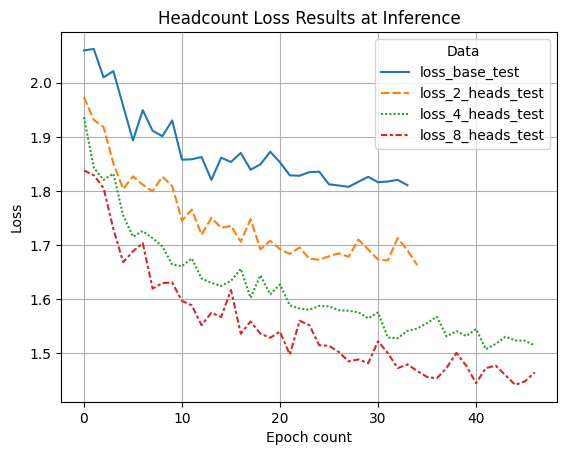

In [54]:
Headcount_Loss = sns.lineplot(data = vit_results_df[['loss_base_test', 'loss_2_heads_test', 'loss_4_heads_test', 'loss_8_heads_test']])
plt.title("Headcount Loss Results at Inference")
plt.xlabel('Epoch count')
plt.ylabel('Loss')
plt.legend(title = 'Data')
plt.grid(True)
plt.savefig('/home/exouser/VSCODE_NN/plots/head_loss.png')
plt.show()

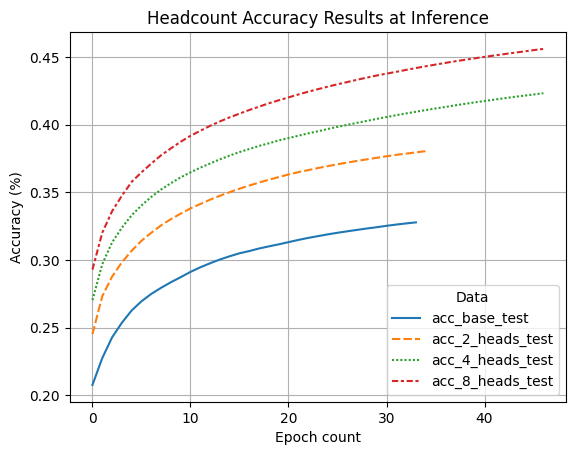

In [53]:
Headcount_accuracy = sns.lineplot(data = vit_results_df[['acc_base_test', 'acc_2_heads_test', 'acc_4_heads_test', 'acc_8_heads_test']])
plt.title("Headcount Accuracy Results at Inference")
plt.xlabel('Epoch count')
plt.ylabel('Accuracy (%)')
plt.legend(title = 'Data')
plt.grid(True)
plt.savefig('/home/exouser/VSCODE_NN/plots/head_acc.png')
plt.show()

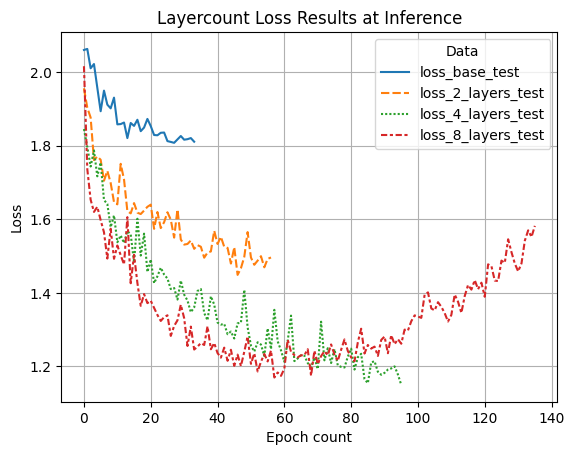

In [52]:
Layercount_loss = sns.lineplot(data = vit_results_df[['loss_base_test', 'loss_2_layers_test', 'loss_4_layers_test', 'loss_8_layers_test']])
plt.title("Layercount Loss Results at Inference")
plt.xlabel('Epoch count')
plt.ylabel('Loss')
plt.legend(title = 'Data')
plt.grid(True)
plt.savefig('/home/exouser/VSCODE_NN/plots/layer_loss.png')
plt.show()

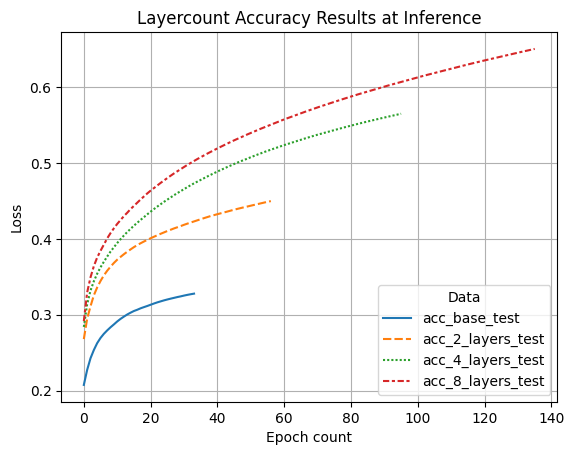

In [51]:
Layercount_acc = sns.lineplot(data = vit_results_df[['acc_base_test', 'acc_2_layers_test', 'acc_4_layers_test', 'acc_8_layers_test']])
plt.title("Layercount Accuracy Results at Inference")
plt.xlabel('Epoch count')
plt.ylabel('Loss')
plt.legend(title = 'Data')
plt.grid(True)
plt.savefig('/home/exouser/VSCODE_NN/plots/layer_acc.png')
plt.show()

# Adding A CNN (if Time)

we need to update the cnn to be less in depth the make it more indepth, we could do 3 tests where each gets more in depth. We need to make the cnn dynamic however. image size should not be fixed, we are convoluting down to a 16x16. This acts as the pixel count in the Vit, ViT Pixel count will be readjusted to 1 ( no issue on computation, this is waht convolution is for).

In [46]:
class BirdClassifier_update(nn.Module):
    def __init__(self,
                 cnn_state=False, # Whether to use CNN before ViT
                 image_size=256,
                 patch_size=16,
                 num_class=10,
                 dim=256,
                 layer_count=1,
                 head_count=1,
                 transformer_ff_neurons=256,
                 transformer_dropout=0.2):
        super().__init__()
        
        self.cnn_state = cnn_state
        self.image_size = image_size

        if cnn_state:
            self.cnn = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=4, padding=2), 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                
                nn.Conv2d(16, 32, kernel_size=3, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),

                nn.Conv2d(32,3, kernel_size=3, padding=1),
                nn.ReLU(),

                nn.ReLU(),
                nn.AdaptiveAvgPool2d((self.image_size, self.image_size))  # Resize to ViT input
            )

        self.vision_transformer = ViT(
            image_size=self.image_size,
            patch_size=patch_size,
            num_classes=num_class,
            dim=dim,
            depth=layer_count,
            heads=head_count,
            mlp_dim=transformer_ff_neurons,
            dropout=transformer_dropout,
            emb_dropout=transformer_dropout,
            channels=3
        )
        

    def forward(self, x):
        if self.cnn_state:
            x = self.cnn(x)
            #print(x.shape)
            #batch_size, channels, height, width = x.size()
            #x = x.flatten(2)
            #unfold = nn.Unfold(kernel_size = 16, stride = 16)
            #x = unfold(x)
            #x = x.flatten(2)
            #print(x.shape)
            #x = x.transpose(1,2)
            #print(x.shape)
        #print(x.shape)
        x = self.vision_transformer(x)
        return x



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn_1 = BirdClassifier_update(cnn_state=True, dim= 256, layer_count=1, head_count = 1).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_cnn_1.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_cnn_1 = []
accuracy_scores_train_cnn_1 = []

loss_scores_test_cnn_1 = []
accuracy_scores_test_cnn_1 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_cnn_1, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_cnn_1, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_cnn_1.append(train_acc)
    loss_scores_train_cnn_1.append(train_loss)

    accuracy_scores_test_cnn_1.append(test_acc)
    loss_scores_test_cnn_1.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TRAINIGN:   0%|          | 0/587 [00:00<?, ?it/s]

TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.37it/s]


Train Acc: 0.1806 | Train Loss: 2.1672 | Test Acc: 0.1915 | Test Loss: 2.0388369933277573

Epoch 2


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.33it/s]


Train Acc: 0.2048 | Train Loss: 2.0631 | Test Acc: 0.2086 | Test Loss: 2.0110756977885758

Epoch 3


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.37it/s]


Train Acc: 0.2196 | Train Loss: 2.0126 | Test Acc: 0.2226 | Test Loss: 1.9703841817622283

Epoch 4


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.25it/s]


Train Acc: 0.2298 | Train Loss: 1.9918 | Test Acc: 0.2319 | Test Loss: 1.9576609069798268

Epoch 5


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.30it/s]


Train Acc: 0.2374 | Train Loss: 1.9826 | Test Acc: 0.2391 | Test Loss: 1.9687287580399286

Epoch 6


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.80it/s]


Train Acc: 0.2444 | Train Loss: 1.9605 | Test Acc: 0.2463 | Test Loss: 1.9279996813560019

Epoch 7


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.64it/s]


Train Acc: 0.2512 | Train Loss: 1.9426 | Test Acc: 0.2521 | Test Loss: 2.0224578867153244

Epoch 8


TESTING: 100%|██████████| 147/147 [00:08<00:00, 18.06it/s]


Train Acc: 0.2564 | Train Loss: 1.9348 | Test Acc: 0.2576 | Test Loss: 1.934128357439625

Epoch 9


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.39it/s]


Train Acc: 0.2611 | Train Loss: 1.9264 | Test Acc: 0.2622 | Test Loss: 1.9089815795016127

Epoch 10


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.61it/s]


Train Acc: 0.2661 | Train Loss: 1.9054 | Test Acc: 0.2671 | Test Loss: 1.9134614427073473

Epoch 11


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.40it/s]


Train Acc: 0.2706 | Train Loss: 1.8897 | Test Acc: 0.2716 | Test Loss: 1.9017056834941009

Epoch 12


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.30it/s]


Train Acc: 0.2736 | Train Loss: 1.9180 | Test Acc: 0.2734 | Test Loss: 1.985227176121303
No improvement. Early stopping counter: 1/3

Epoch 13


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.26it/s]


Train Acc: 0.2759 | Train Loss: 1.8937 | Test Acc: 0.2767 | Test Loss: 1.8886986687069847

Epoch 14


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.60it/s]


Train Acc: 0.2791 | Train Loss: 1.8877 | Test Acc: 0.2797 | Test Loss: 1.8744094712393624
No improvement. Early stopping counter: 1/3

Epoch 15


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.32it/s]


Train Acc: 0.2821 | Train Loss: 1.8680 | Test Acc: 0.2827 | Test Loss: 1.8754129020535215

Epoch 16


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.81it/s]


Train Acc: 0.2855 | Train Loss: 1.8425 | Test Acc: 0.2860 | Test Loss: 1.868752620658096

Epoch 17


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.79it/s]


Train Acc: 0.2884 | Train Loss: 1.8461 | Test Acc: 0.2889 | Test Loss: 1.8679249116352625
No improvement. Early stopping counter: 1/3

Epoch 18


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.05it/s]


Train Acc: 0.2909 | Train Loss: 1.8505 | Test Acc: 0.2914 | Test Loss: 1.8825860810117656

Epoch 19


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.55it/s]


Train Acc: 0.2936 | Train Loss: 1.8266 | Test Acc: 0.2941 | Test Loss: 1.864881242213606
No improvement. Early stopping counter: 1/3

Epoch 20


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.64it/s]


Train Acc: 0.2961 | Train Loss: 1.8232 | Test Acc: 0.2966 | Test Loss: 1.8182378926244722

Epoch 21


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.23it/s]


Train Acc: 0.2977 | Train Loss: 1.8729 | Test Acc: 0.2974 | Test Loss: 1.9976103013875532
No improvement. Early stopping counter: 1/3

Epoch 22


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.30it/s]


Train Acc: 0.2973 | Train Loss: 1.9382 | Test Acc: 0.2974 | Test Loss: 1.8997593866724547
No improvement. Early stopping counter: 2/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.59it/s]

Train Acc: 0.2980 | Train Loss: 1.8987 | Test Acc: 0.2982 | Test Loss: 1.9077521619342623
No improvement. Early stopping counter: 3/3
Early stopping triggered.


In [48]:
class BirdClassifier_update(nn.Module):
    def __init__(self,
                 cnn_state=False, # Whether to use CNN before ViT
                 image_size=256,
                 patch_size=16,
                 num_class=10,
                 dim=256,
                 layer_count=1,
                 head_count=1,
                 transformer_ff_neurons=256,
                 transformer_dropout=0.2):
        super().__init__()
        
        self.cnn_state = cnn_state
        self.image_size = image_size

        if cnn_state:
            self.cnn = nn.Sequential(
                nn.Conv2d(3, 6, kernel_size=3, stride=4, padding=2), 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                
                nn.Conv2d(6, 12, kernel_size=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=1),

                nn.Conv2d(12,16, kernel_size=3, padding=1),
                nn.ReLU(),
                
                nn.Conv2d(16, 12, kernel_size = 3, stride = 1),
                nn.ReLU(),
                
                nn.Conv2d(12, 3, kernel_size = 3, stride = 1),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((self.image_size, self.image_size))  # Resize to ViT input
            )

        self.vision_transformer = ViT(
            image_size=self.image_size,
            patch_size=patch_size,
            num_classes=num_class,
            dim=dim,
            depth=layer_count,
            heads=head_count,
            mlp_dim=transformer_ff_neurons,
            dropout=transformer_dropout,
            emb_dropout=transformer_dropout,
            channels=3
        )
        

    def forward(self, x):
        if self.cnn_state:
            x = self.cnn(x)
            #print(x.shape)
            #batch_size, channels, height, width = x.size()
            #x = x.flatten(2)
            #unfold = nn.Unfold(kernel_size = 16, stride = 16)
            #x = unfold(x)
            #x = x.flatten(2)
            #print(x.shape)
            #x = x.transpose(1,2)
            #print(x.shape)
        #print(x.shape)
        x = self.vision_transformer(x)
        return x


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn_2 = BirdClassifier_update(cnn_state=True, dim= 256, layer_count=1, head_count = 1).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_cnn_2.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_cnn_2 = []
accuracy_scores_train_cnn_2 = []

loss_scores_test_cnn_2 = []
accuracy_scores_test_cnn_2 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_cnn_1, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_cnn_1, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_cnn_2.append(train_acc)
    loss_scores_train_cnn_2.append(train_loss)

    accuracy_scores_test_cnn_2.append(test_acc)
    loss_scores_test_cnn_2.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.33it/s]


Train Acc: 0.3242 | Train Loss: 1.8708 | Test Acc: 0.3242 | Test Loss: 1.9033184992212828

Epoch 2


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.68it/s]


Train Acc: 0.3252 | Train Loss: 1.8697 | Test Acc: 0.3248 | Test Loss: 1.9108031160977421
No improvement. Early stopping counter: 1/3

Epoch 3


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.72it/s]


Train Acc: 0.3250 | Train Loss: 1.8677 | Test Acc: 0.3251 | Test Loss: 1.9056321804215308
No improvement. Early stopping counter: 2/3

Epoch 4


TESTING: 100%|██████████| 147/147 [00:08<00:00, 17.20it/s]

Train Acc: 0.3254 | Train Loss: 1.8693 | Test Acc: 0.3253 | Test Loss: 1.9070118568381484
No improvement. Early stopping counter: 3/3
Early stopping triggered.


In [52]:
from itertools import zip_longest
column_names = [ 
                'loss_cnn_1_train',
                'loss_cnn_2_train',
           
                'acc_cnn_1_train',
                'acc_cnn_2_train',
                #test
            
                'loss_cnn_1_test',
                'loss_cnn_2_test',
        
                'acc_cnn_1_test',
                'acc_cnn_2_test',
]


raw_data = [
            loss_scores_train_cnn_1,
            loss_scores_train_cnn_2,
     
            accuracy_scores_train_cnn_1,
            accuracy_scores_train_cnn_2,
            #test
         
            loss_scores_test_cnn_1,
            loss_scores_test_cnn_2,
    
            accuracy_scores_test_cnn_1,
            accuracy_scores_test_cnn_2
]


cnn_results_df = pd.DataFrame(list(zip_longest(*raw_data)), columns = column_names)
cnn_results_df

,loss_cnn_1_train,loss_cnn_2_train,acc_cnn_1_train,acc_cnn_2_train,loss_cnn_1_test,loss_cnn_2_test,acc_cnn_1_test,acc_cnn_2_test
0,2.167231,1.870849,0.180624,0.324224,2.038837,1.903318,0.191485,0.324177
1,2.063125,1.869720,0.204818,0.325216,2.011076,1.910803,0.208639,0.324795
2,2.012576,1.867733,0.219570,0.324990,1.970384,1.905632,0.222554,0.325065
3,1.991794,1.869298,0.229809,0.325393,1.957661,1.907012,0.231866,0.325312
4,1.982638,NaN,0.237368,NaN,1.968729,NaN,0.239119,NaN
5,1.960532,NaN,0.244425,NaN,1.928000,NaN,0.246292,NaN
6,1.942591,NaN,0.251211,NaN,2.022458,NaN,0.252113,NaN
7,1.934768,NaN,0.256370,NaN,1.934128,NaN,0.257557,NaN
8,1.926355,NaN,0.261072,NaN,1.908982,NaN,0.262236,NaN
9,1.905414,NaN,0.266120,NaN,1.913461,NaN,0.267081,NaN


In [53]:
cnn_results_df.to_csv('/home/exouser/VSCODE_NN/CNN_Testing.csv')